In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import json
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

import sys 
sys.path.append("../../models/")
from functions import plot_style
colors = plot_style("../../fonts/Encode_Sans_Condensed/")

# list of countries
countries = ['Sri Lanka', 'El Salvador', 'Morocco', 'Bolivia', 'Honduras',
             'Philippines', 'Indonesia', 'Pakistan', 'Rwanda', 'Bangladesh',
             'Kyrgyzstan', 'Egypt', 'Mozambique', 'Afghanistan', 'Angola',
             'Ghana', 'Zambia', "Côte d'Ivoire", 'Kenya', 'Uganda']

neighbors = {"Uganda": ["Rwanda", "Kenya", "Democratic Republic of the Congo"],
             "El Salvador": ["Guatemala"],
             "Afghanistan": ["Iran", "Pakistan"], 
             "Egypt": ["Israel"],
             "Zambia": ["Angola", "Mozambique"],
             "Honduras": ["Guatemala", "Nicaragua"],
             "Côte d'Ivoire": ["Ghana"]} 

../../models/functions.py:286: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
def import_covariants():
    # import covariants data 
    with open("./perCountryData.json", "rb") as file:
        data = json.load(file)
    return data


def parse_date(date):
    # parse date in yyyy-mm-dd string format
    els = date.split("-")
    return datetime(int(els[0]), int(els[1]), int(els[2]))


def get_data_country(country):
    # import covariants data for a given country
    data = import_covariants()
    for el in data["regions"][0]['distributions']:
        if el["country"] == country:
            return el 
    return None


def get_delta_prevalence(country):
    # get country data
    data = get_data_country(country)
    if data == None:
        return pd.DataFrame(data={"delta_counts": [], "dates": [], "total_seq": [], "delta_frac": []})

    # get delta prevalence over time
    dates, delta_counts, total_seq = [], [], []
    for el in data['distribution']:
        tot = 0
        for k in el['cluster_counts'].keys():
            if "Delta" in k:
                tot += el['cluster_counts'][k]
        delta_counts.append(tot)

        dates.append(parse_date(el["week"]))
        total_seq.append(el['total_sequences'])

    df = pd.DataFrame(data={"delta_counts": delta_counts, "total_seq": total_seq}, 
                      index=pd.to_datetime(dates))
    df["delta_frac"] = df.delta_counts / df.total_seq
    return df


def logistic(x, a, b):
    return 1 / (1 + np.exp(- a * (x - b)))


def logistic_fit(country, start_date=datetime(2020, 4, 27), end_date=datetime(2021, 11, 1)):
    # fit a logistic function on the prevalence data

    # get prevalence data for country
    if country in neighbors.keys():
        df = pd.DataFrame()
        for nn in neighbors[country]:
            df_temp = get_delta_prevalence(nn)
            df = df.merge(df_temp, right_index=True, left_index=True, how="outer")
        df["delta_frac"] = df[[c for c in df.columns if "delta_frac" in c]].mean(axis=1)
        df["total_seq"] = df[[c for c in df.columns if "total_seq" in c]].sum(axis=1)
    else:
        df = get_delta_prevalence(country)

    if df.empty:
        return df, -1
    df = df.loc[df.index <= end_date]

    # get delta days since start of year (normalize)
    df["x"] = ((df.index - start_date).days)
    df["x_norm"] = df["x"] / df["x"].max()

    # fit
    popt, pcov = curve_fit(logistic, df.x_norm.values, df.delta_frac.values)

    # get date when estimated prevalence was 5% 
    date_th = get_importation_date(df, popt, start_date)  

    # fitted values (fill nan)
    df = df.resample("W-MON").mean()
    df["x_new"] = ((df.index - start_date).days)
    df["x_new"] = df["x_new"] / df["x_new"].max()
    df["delta_frac_fitted"] = logistic(df.x_new.values, *popt)
    sigma_ab = np.sqrt(np.diagonal(pcov)) 
    df["delta_frac_fitted_upper"] = logistic(df.x_new.values, *(popt + sigma_ab))
    df["delta_frac_fitted_lower"] = logistic(df.x_new.values, *(popt - sigma_ab))

    return df, date_th


def get_importation_date(df, popt, start_date, th=0.05):
    xdate_norm = (-1 / popt[0]) * np.log(1 / th - 1) + popt[1]
    xdate = xdate_norm * df["x"].max()
    date = start_date + timedelta(days=xdate)
    return date

Sri Lanka: 2021-05-31 00:46:51.428486
El Salvador: 2021-05-17 09:06:26.621650
Morocco: 2021-05-25 12:19:38.577815
Bolivia: 2021-08-12 10:03:51.433048
Honduras: 2021-05-27 12:54:12.296826
Philippines: 2021-06-07 06:06:24.561541
Indonesia: 2021-04-26 20:27:24.797799
Pakistan: 2021-05-21 16:09:21.064475
Rwanda: 2021-05-13 02:10:19.844849
Bangladesh: 2021-04-01 17:06:16.348359
Kyrgyzstan: 2021-03-30 20:48:44.539893
Egypt: 2021-05-12 18:04:19.435976
Mozambique: 2021-04-17 17:40:27.536568
Afghanistan: 2021-05-02 01:18:49.270598
Angola: 2021-05-07 21:44:50.612441
Ghana: 2021-05-25 09:18:10.325940
Zambia: 2021-04-03 18:17:51.998524
Côte d'Ivoire: 2021-05-25 09:18:10.325940
Kenya: 2021-04-12 00:56:41.251958
Uganda: 2021-03-14 11:54:28.471808


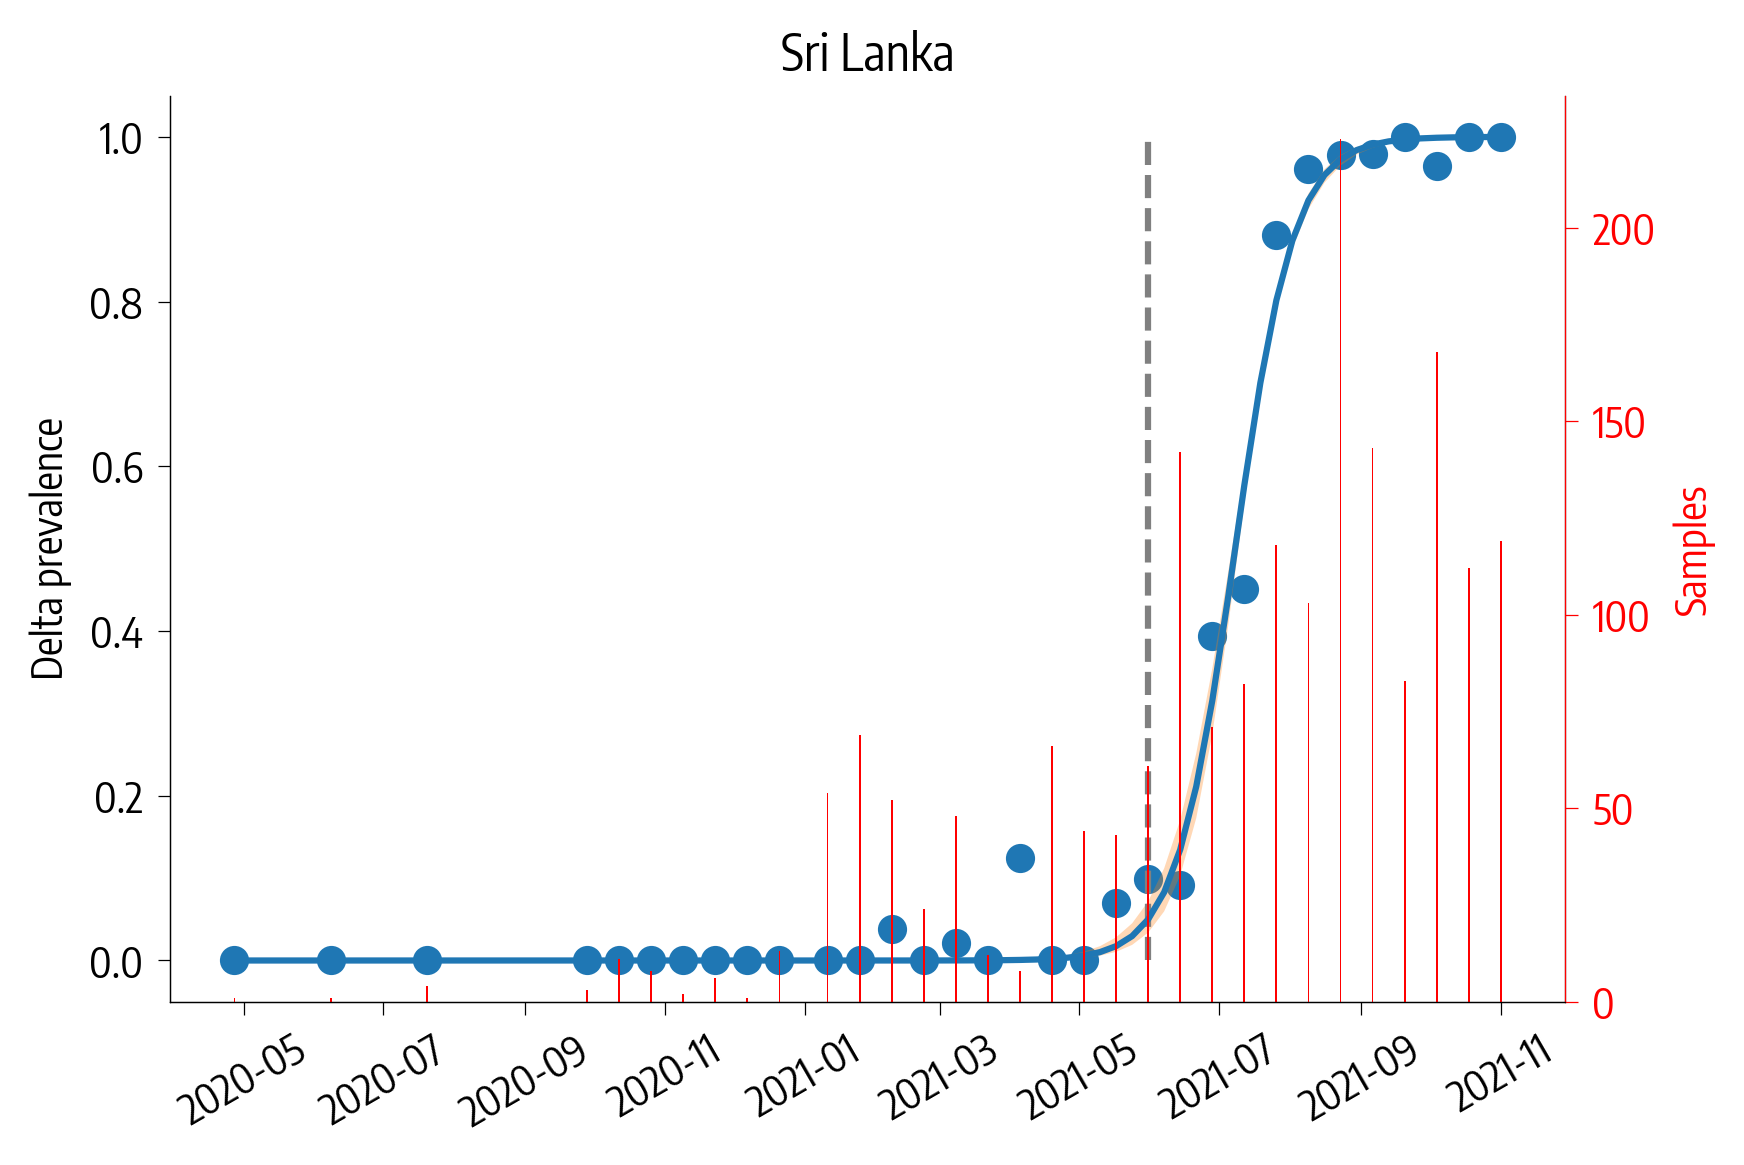

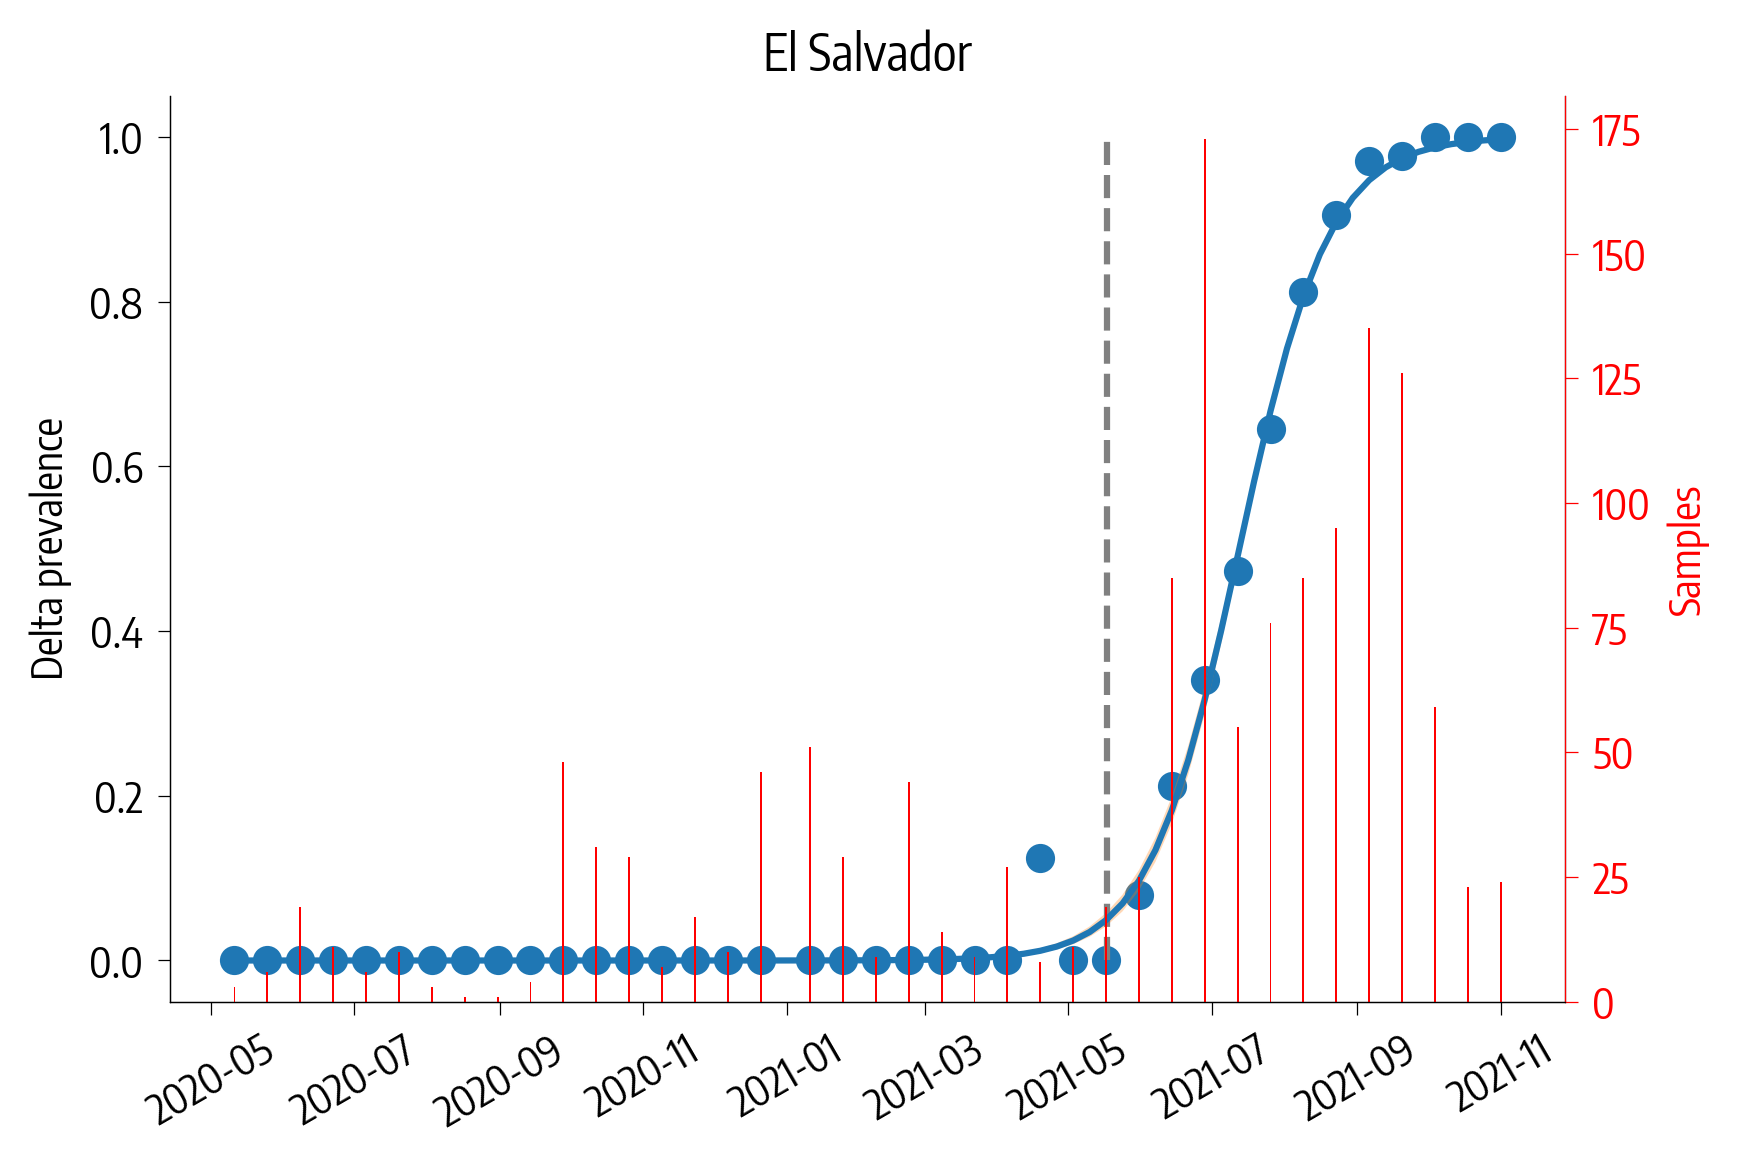

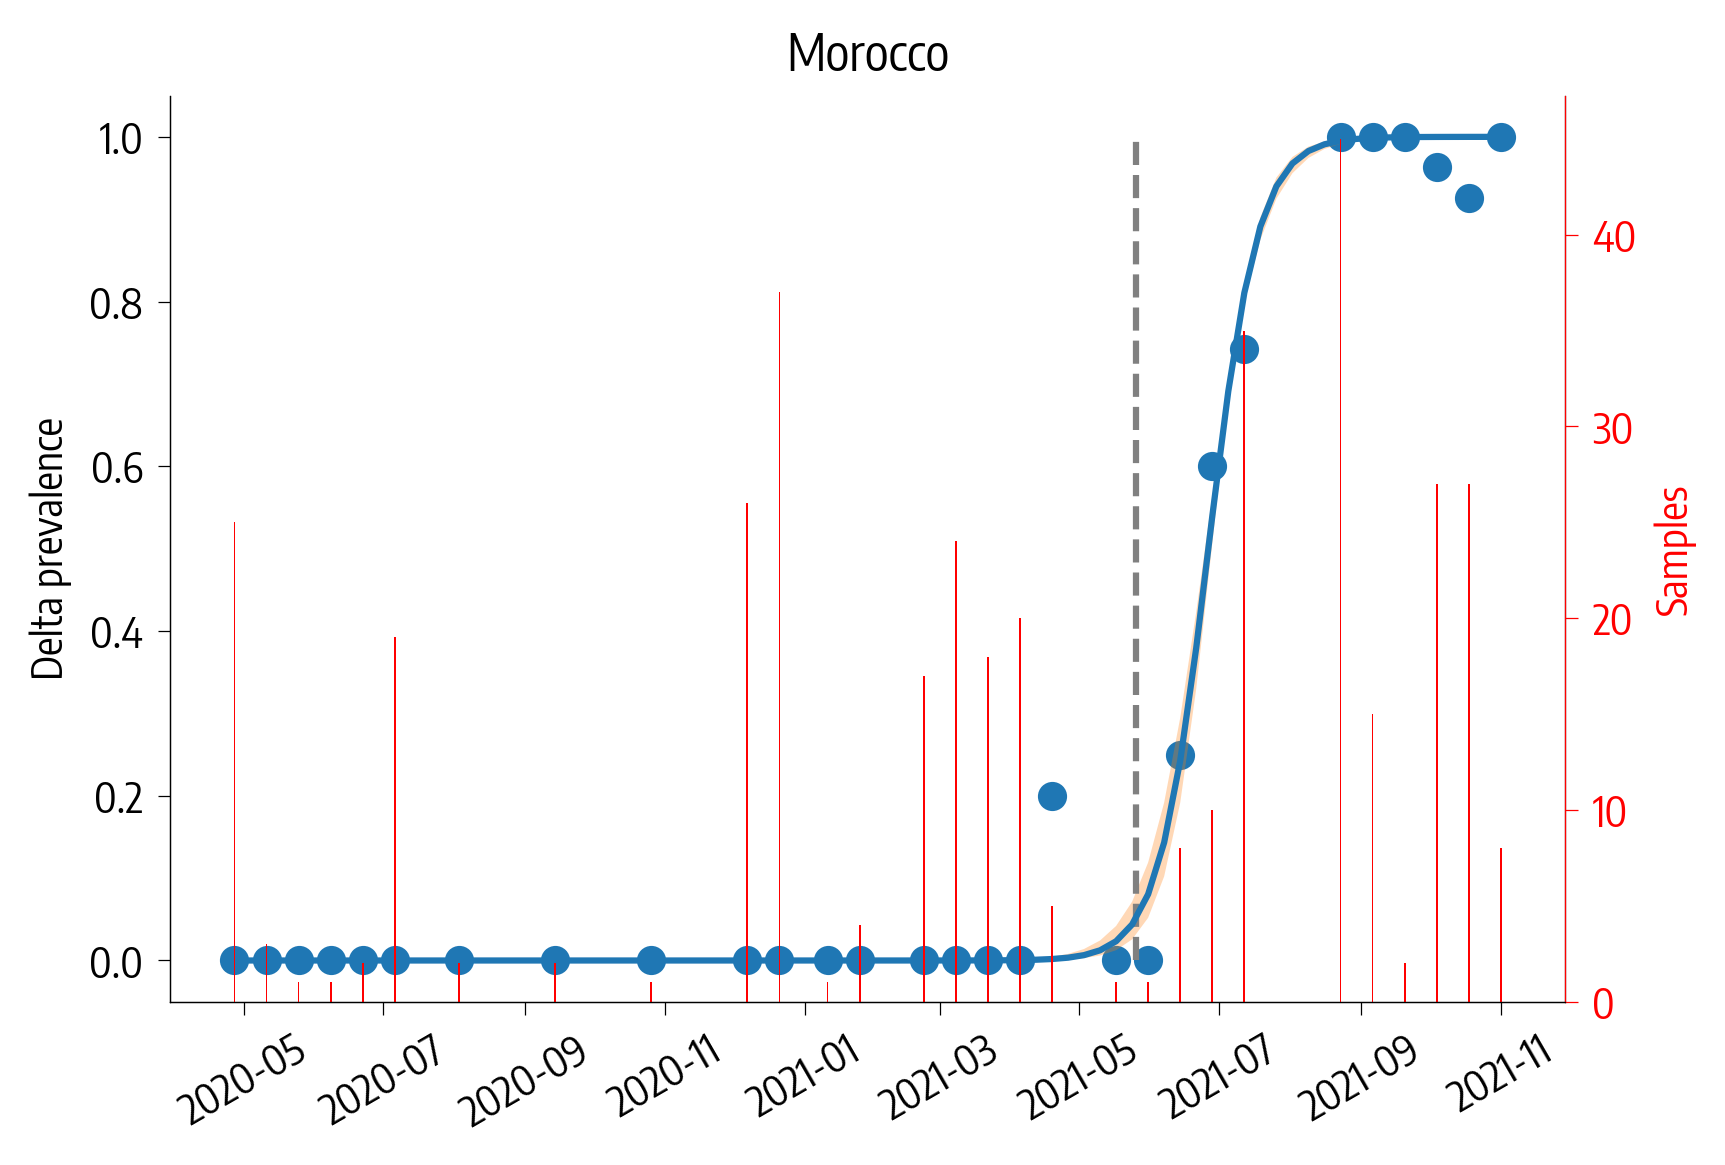

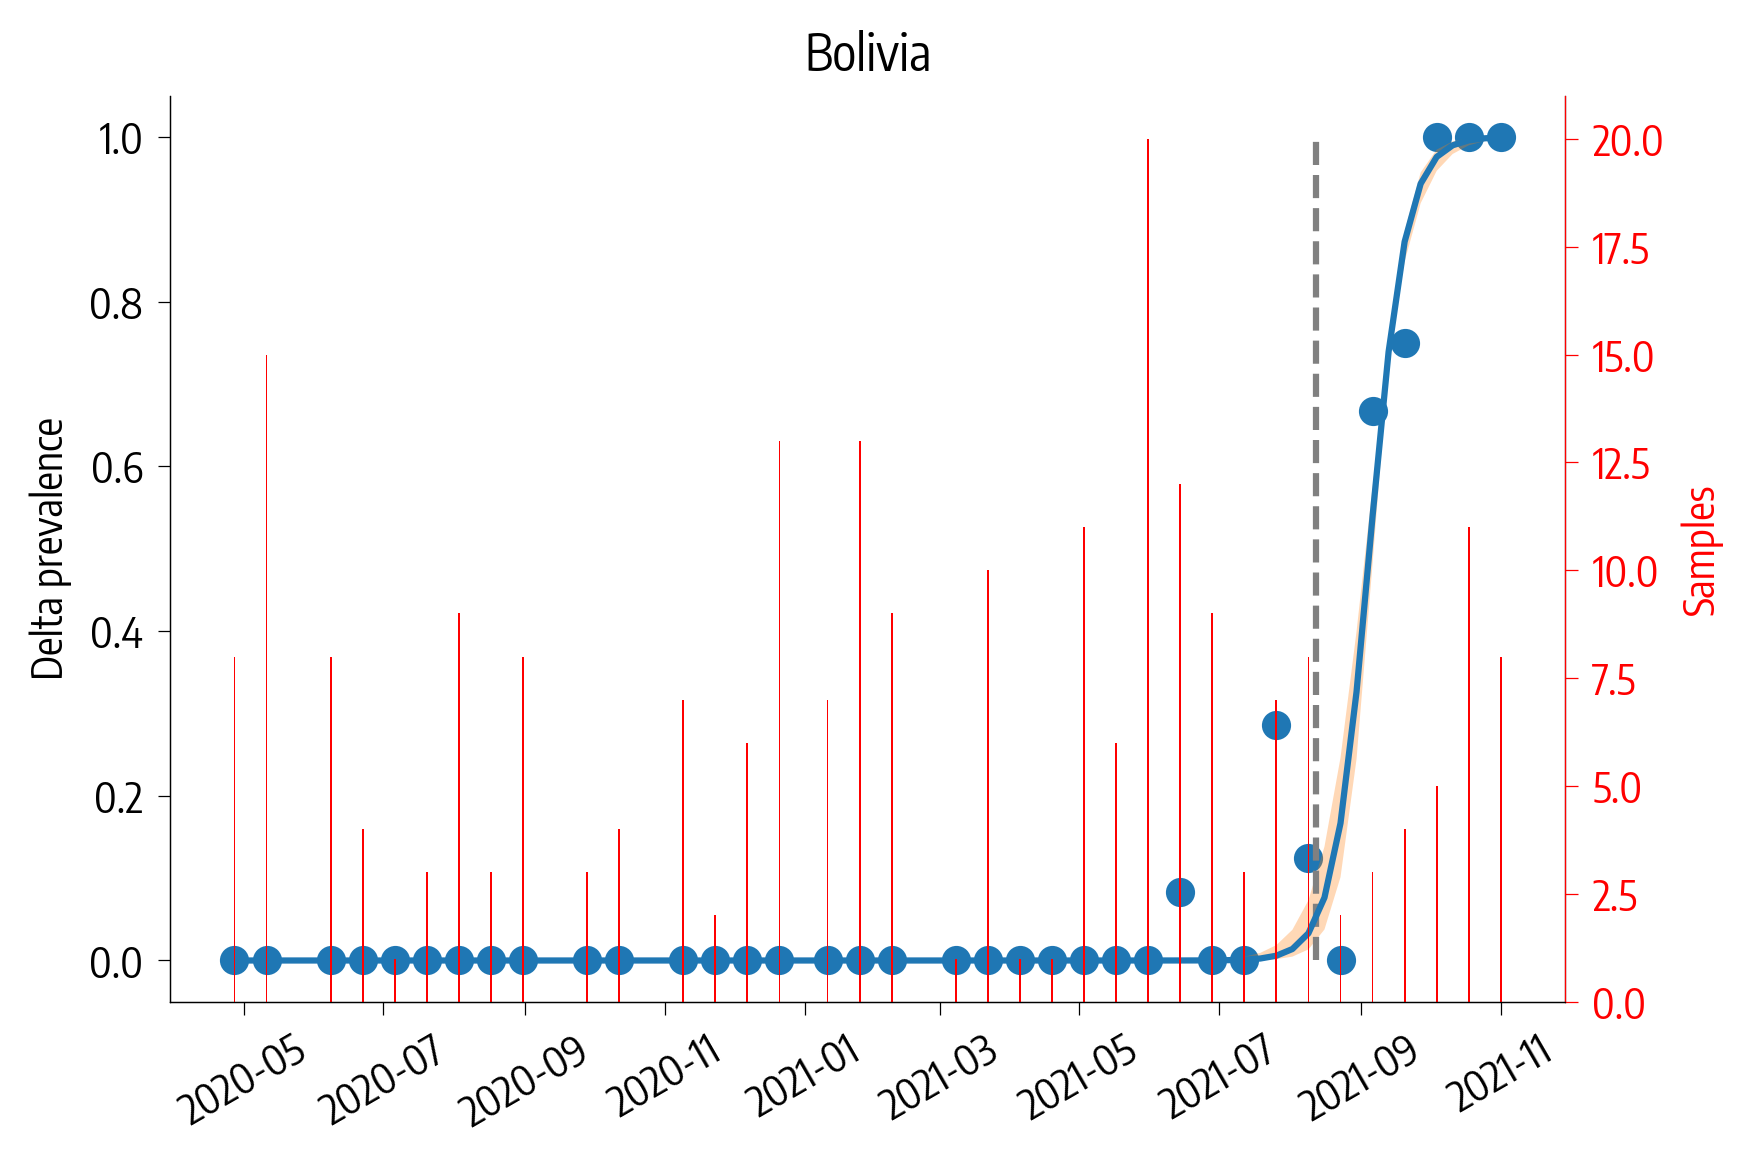

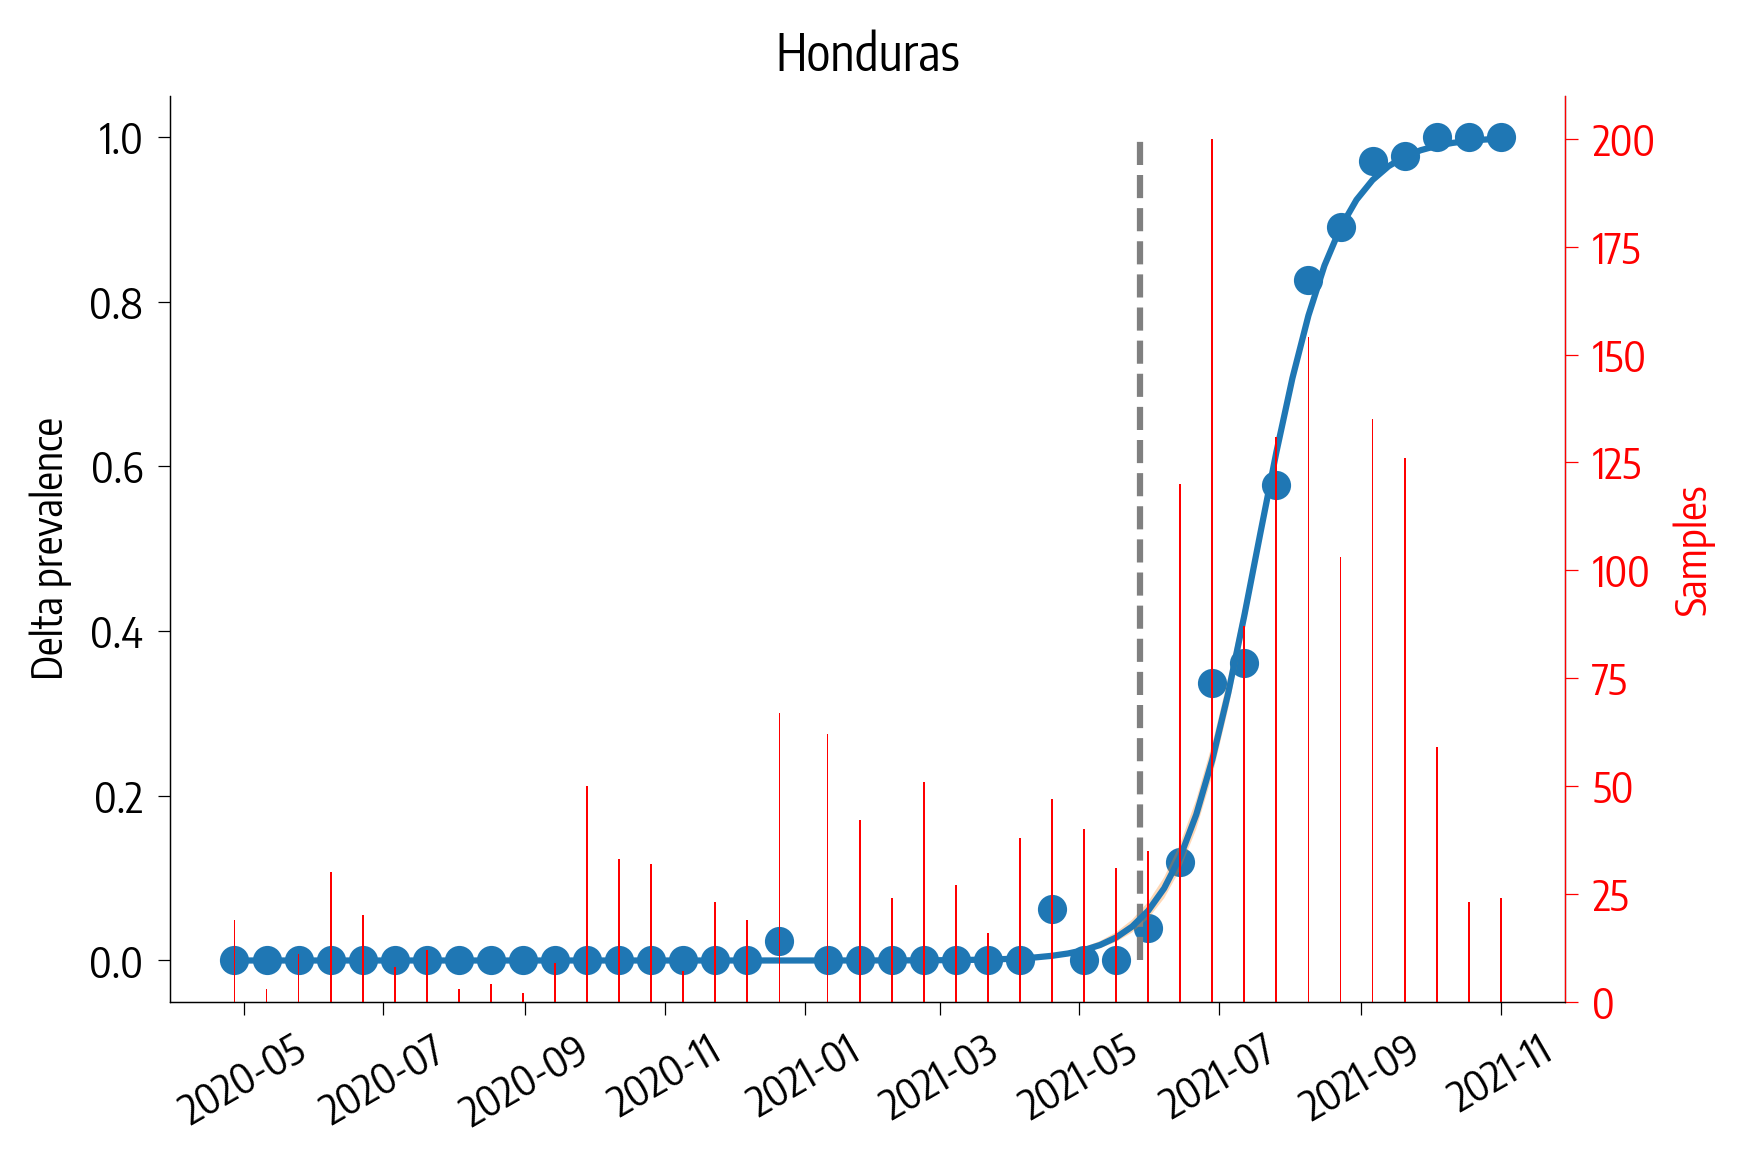

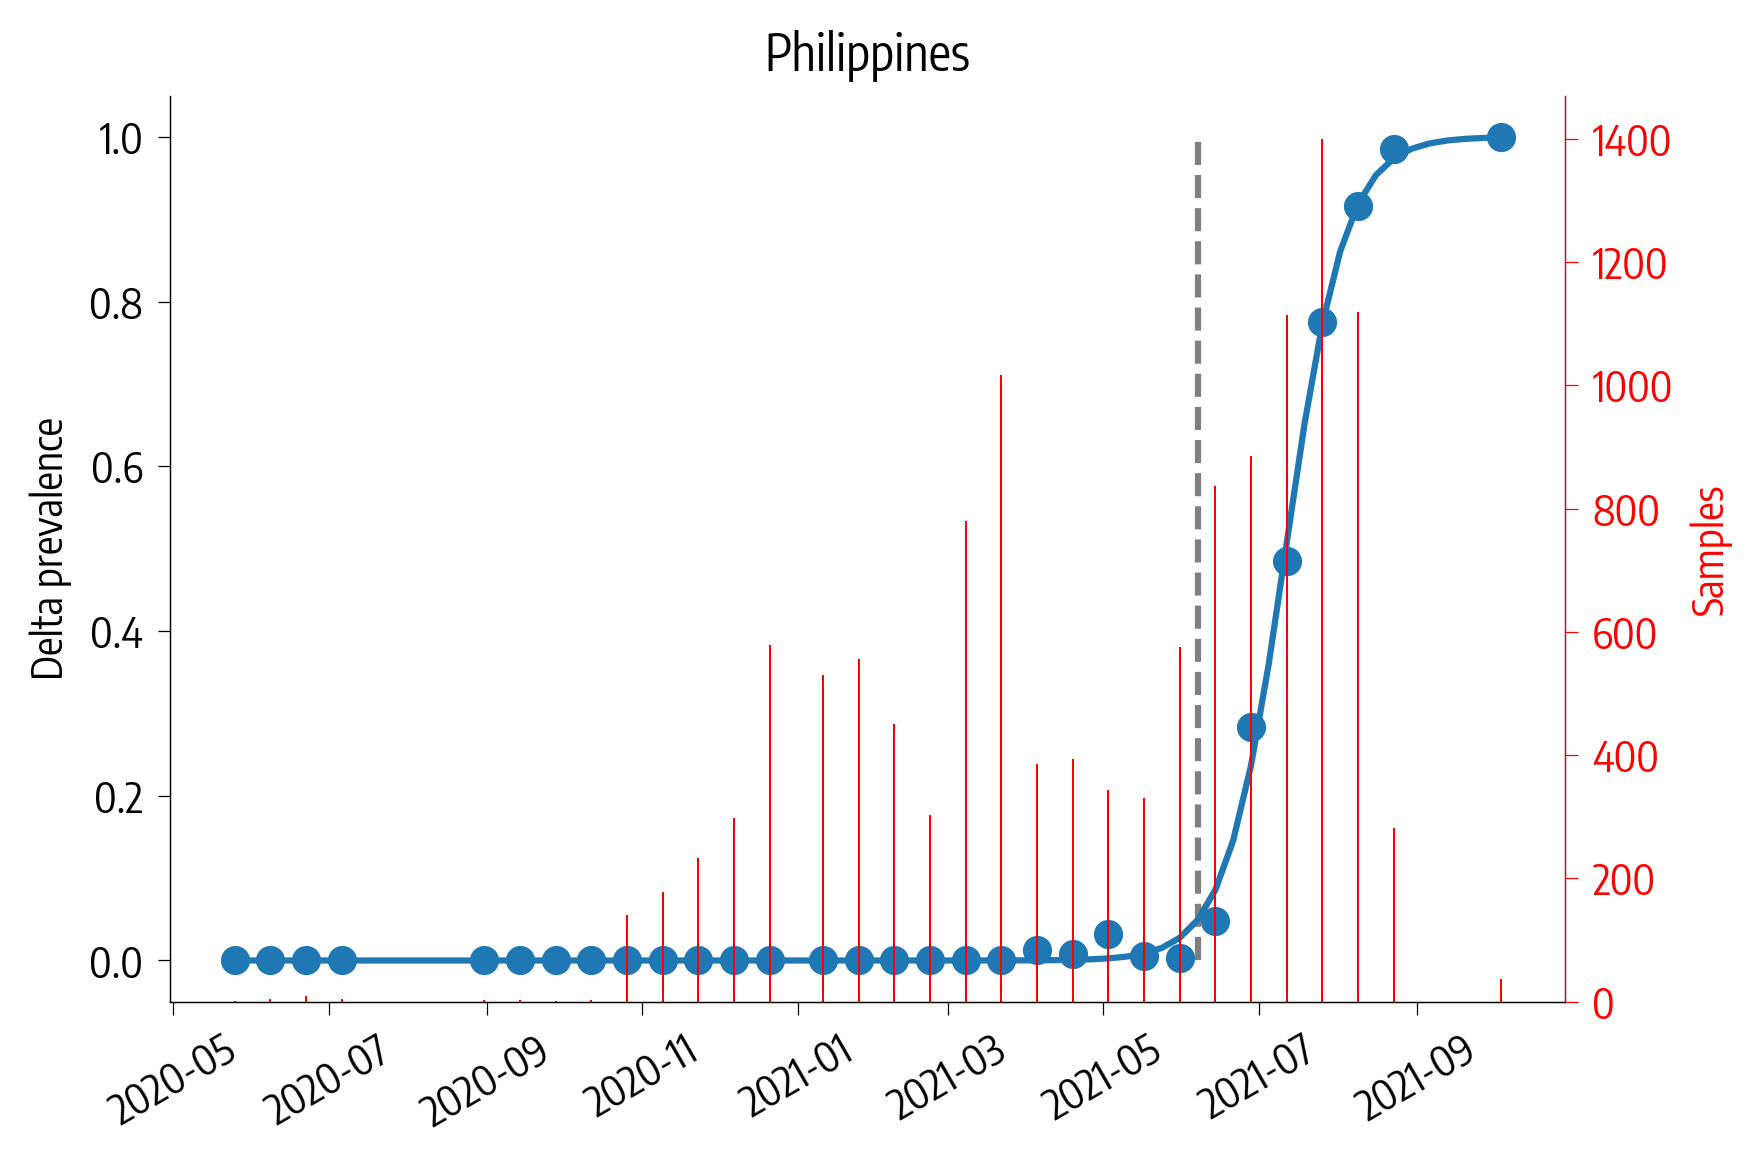

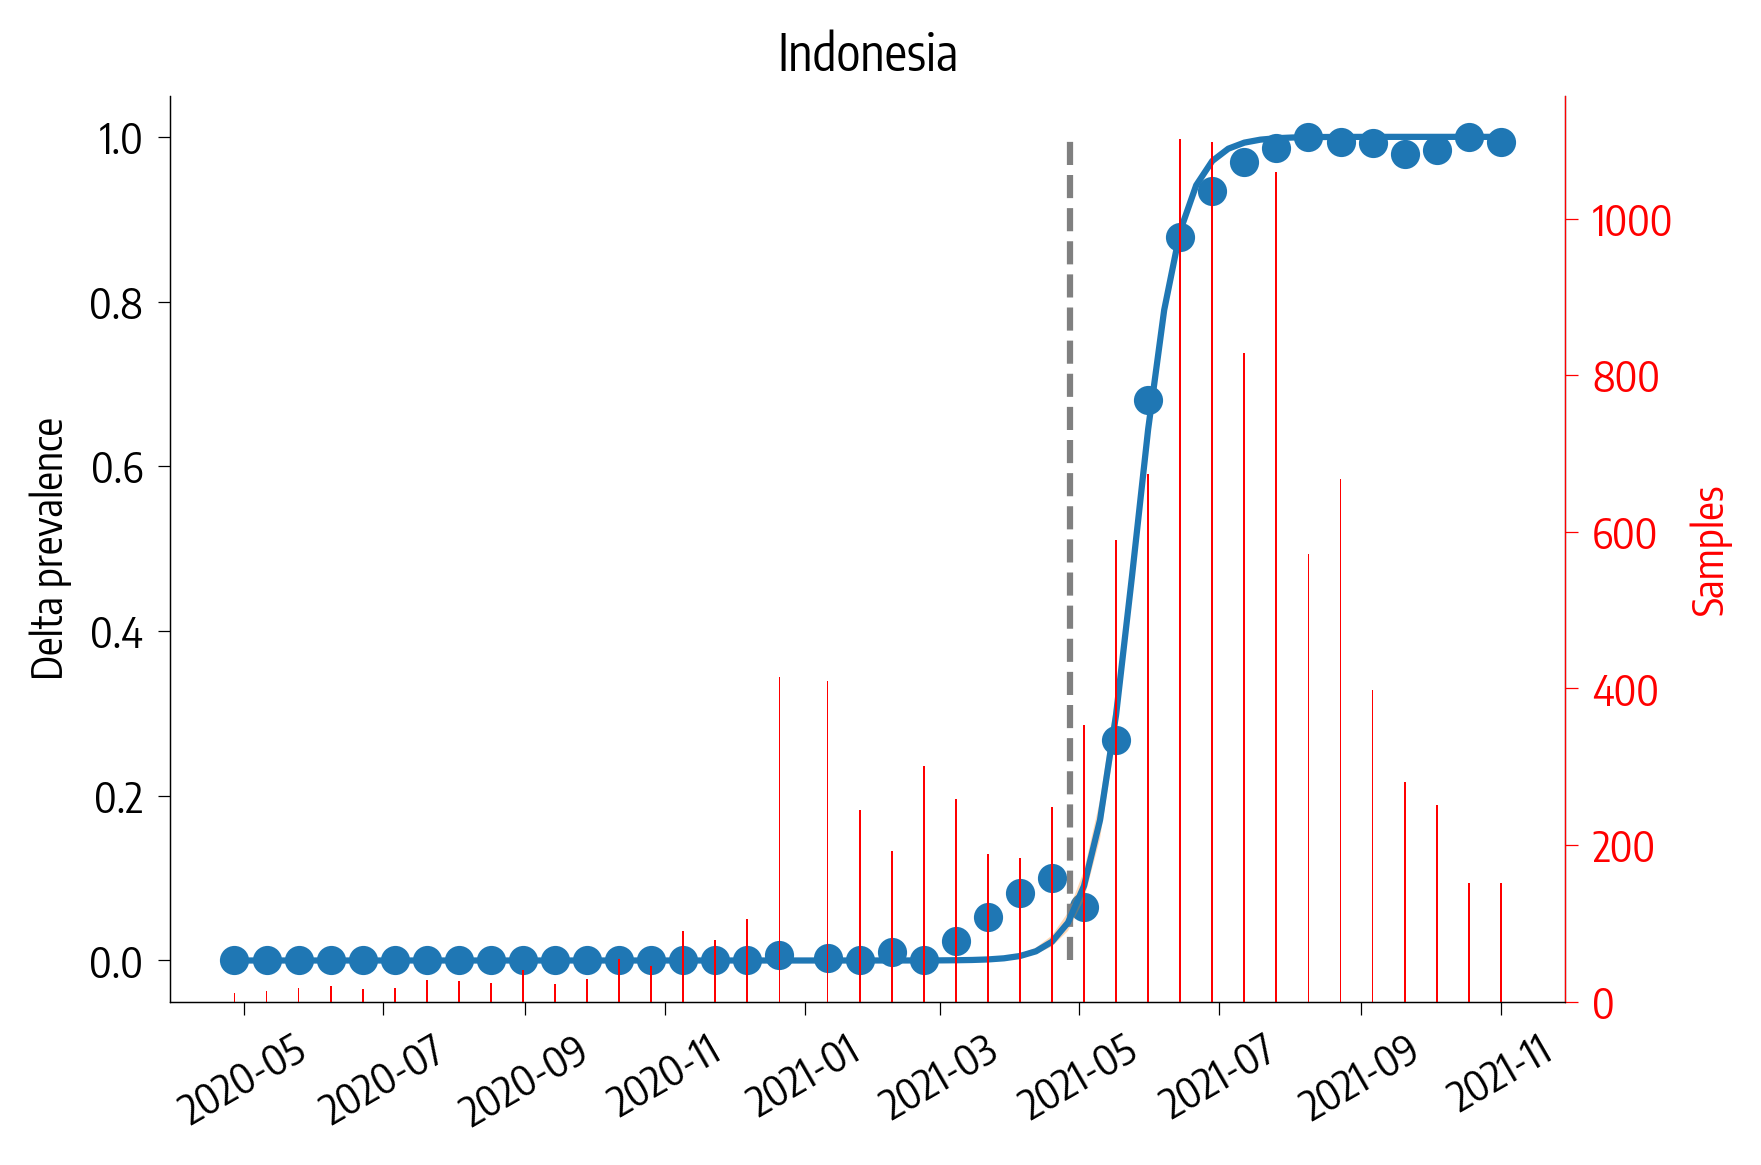

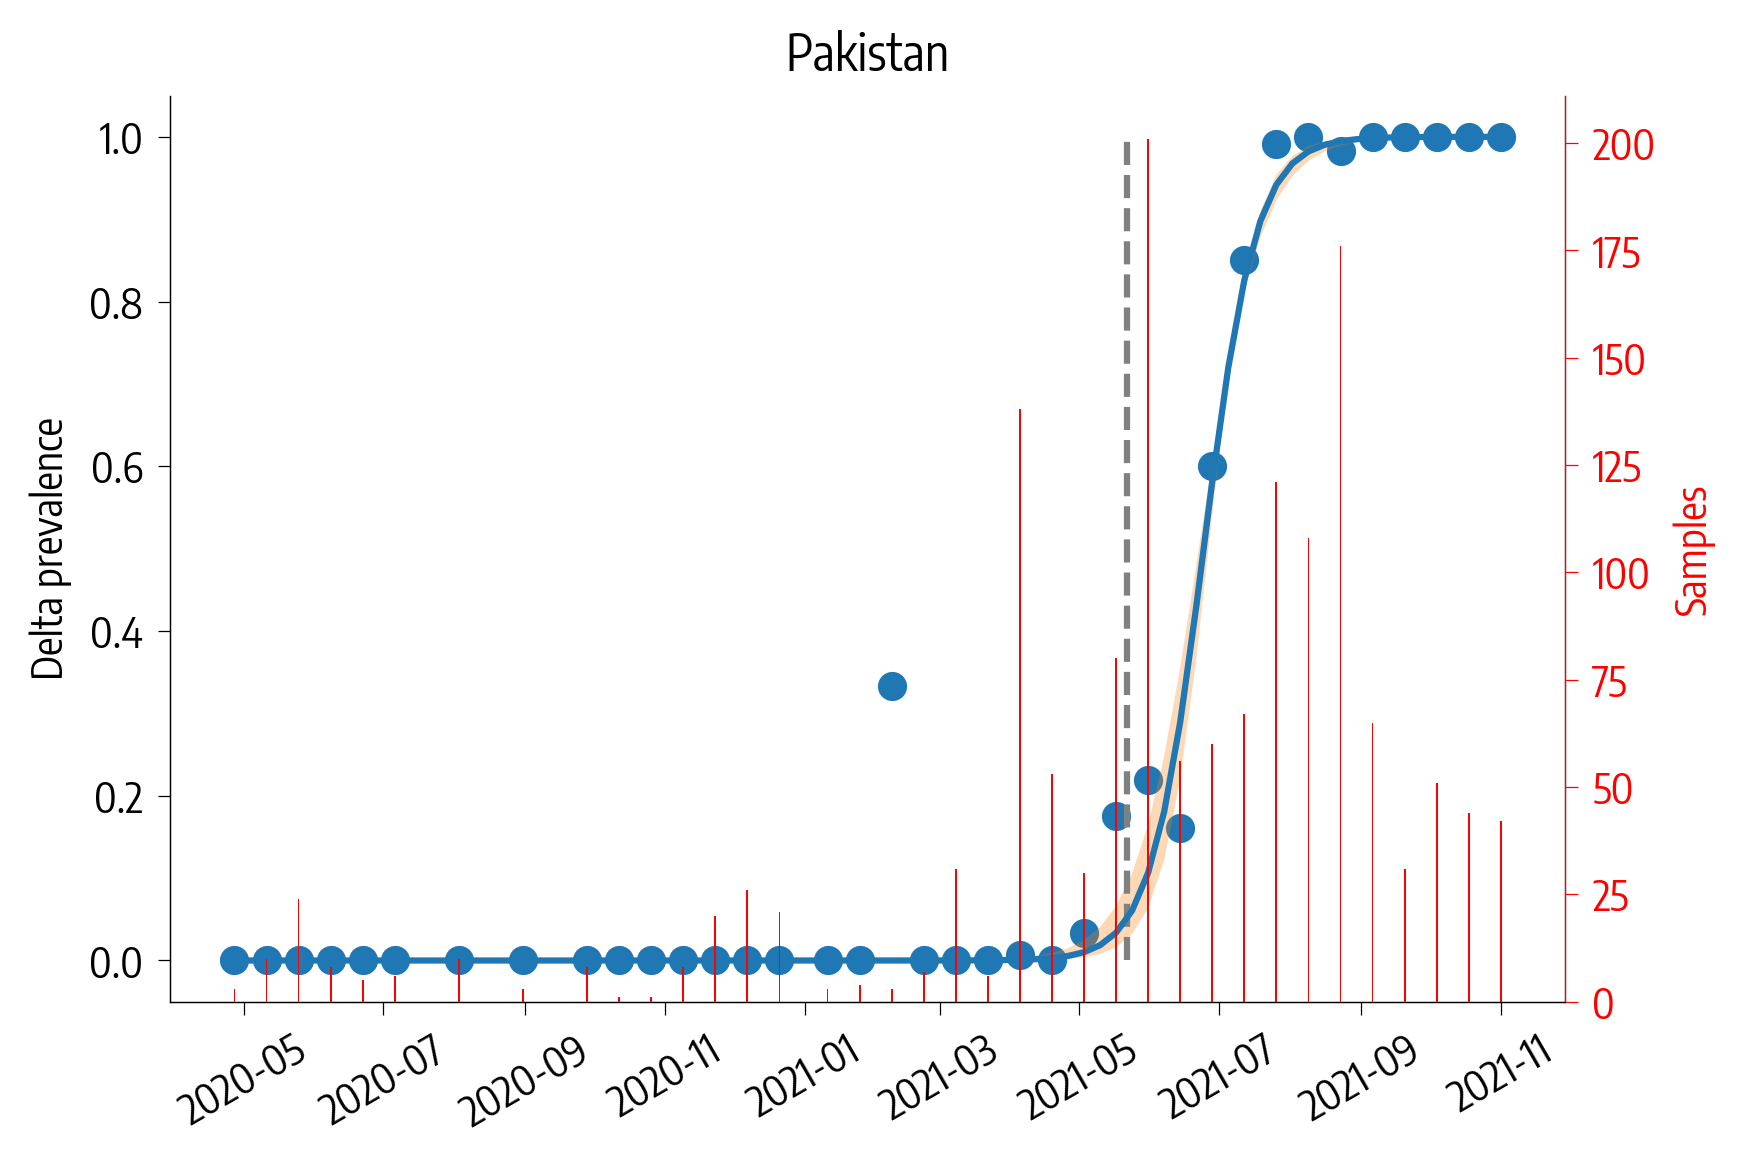

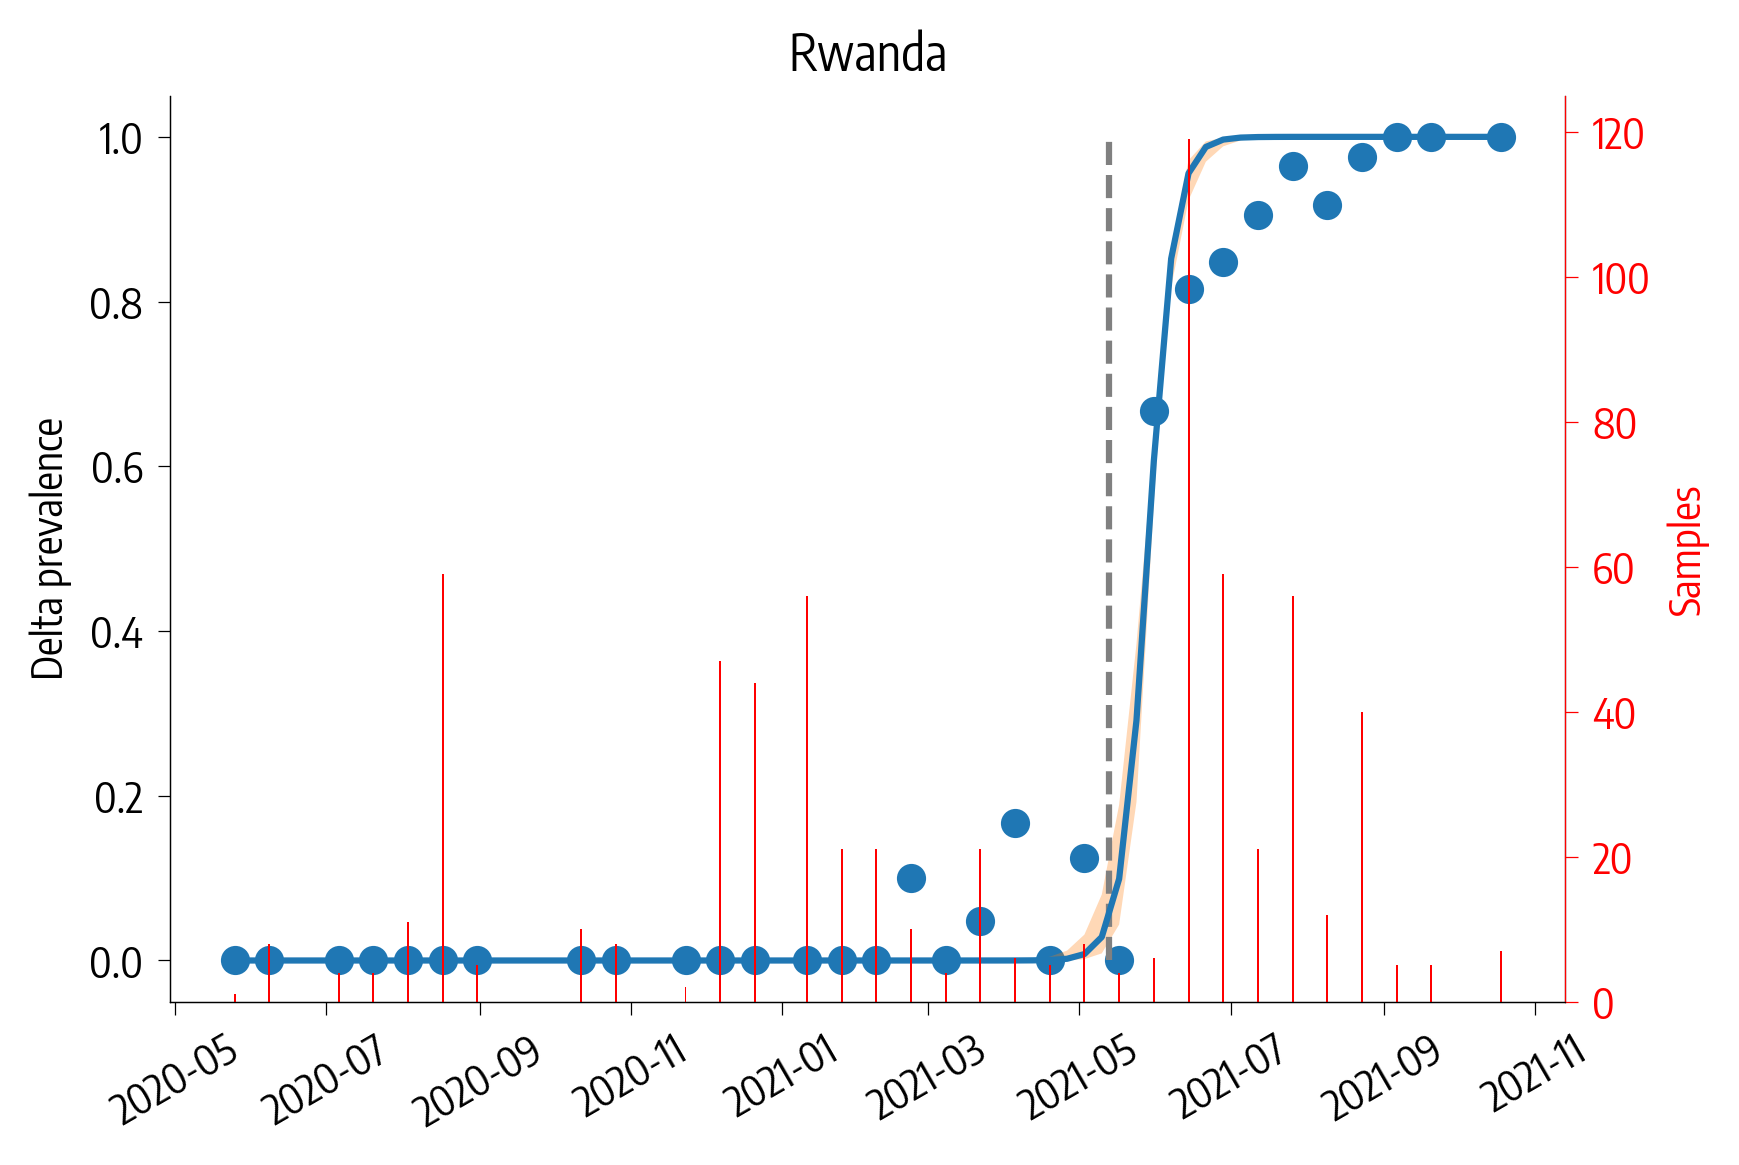

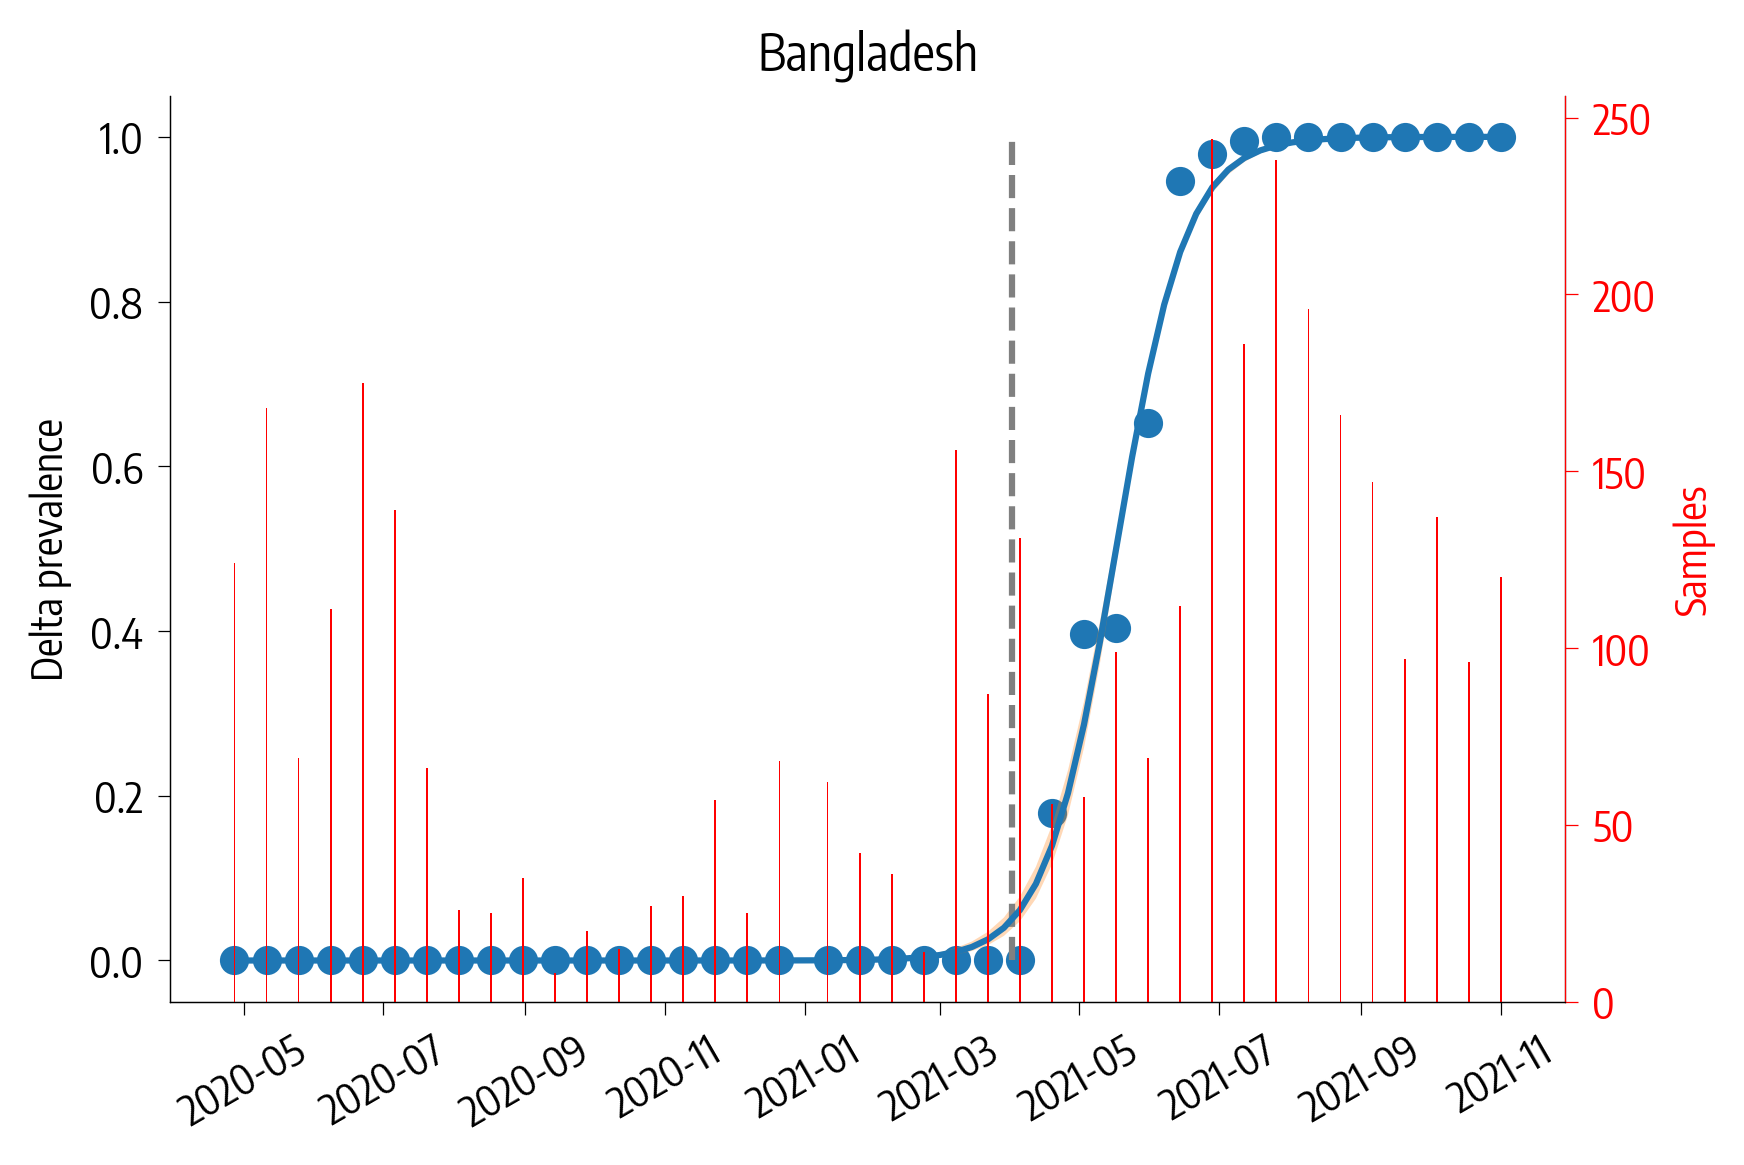

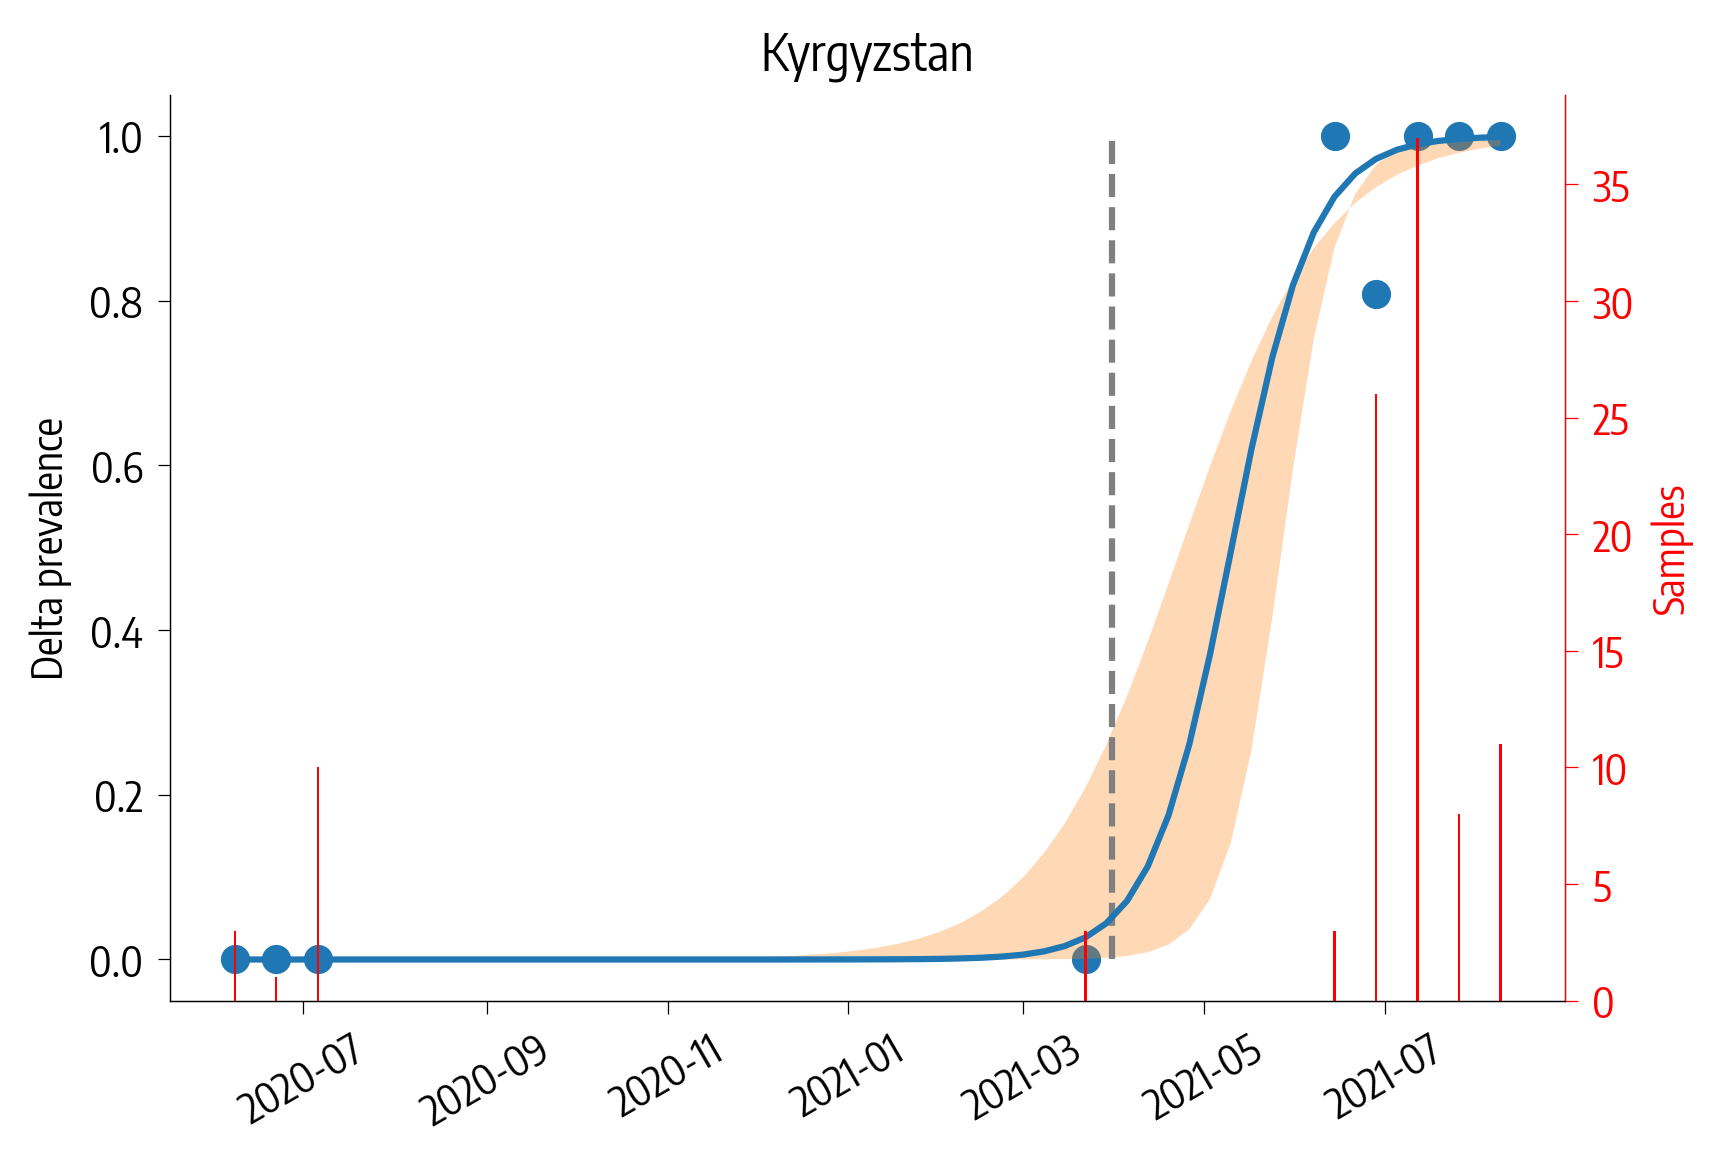

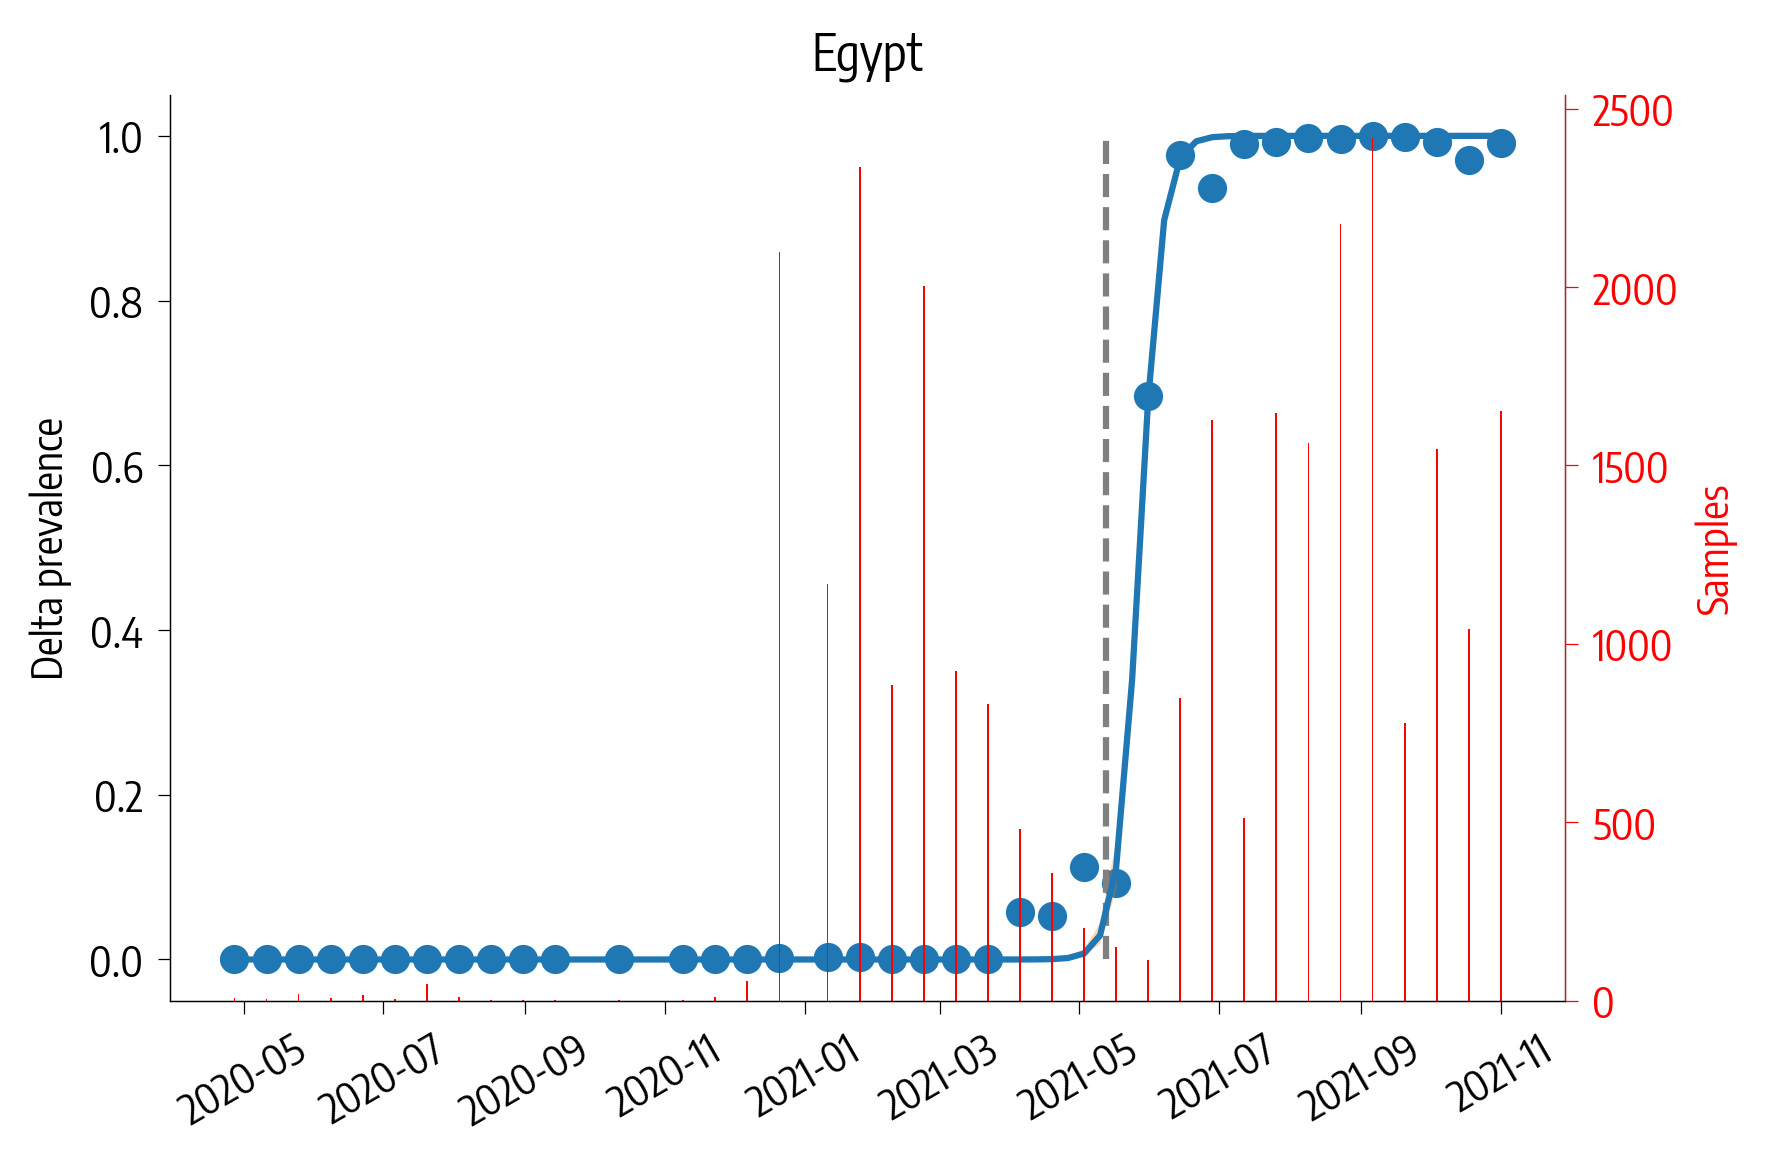

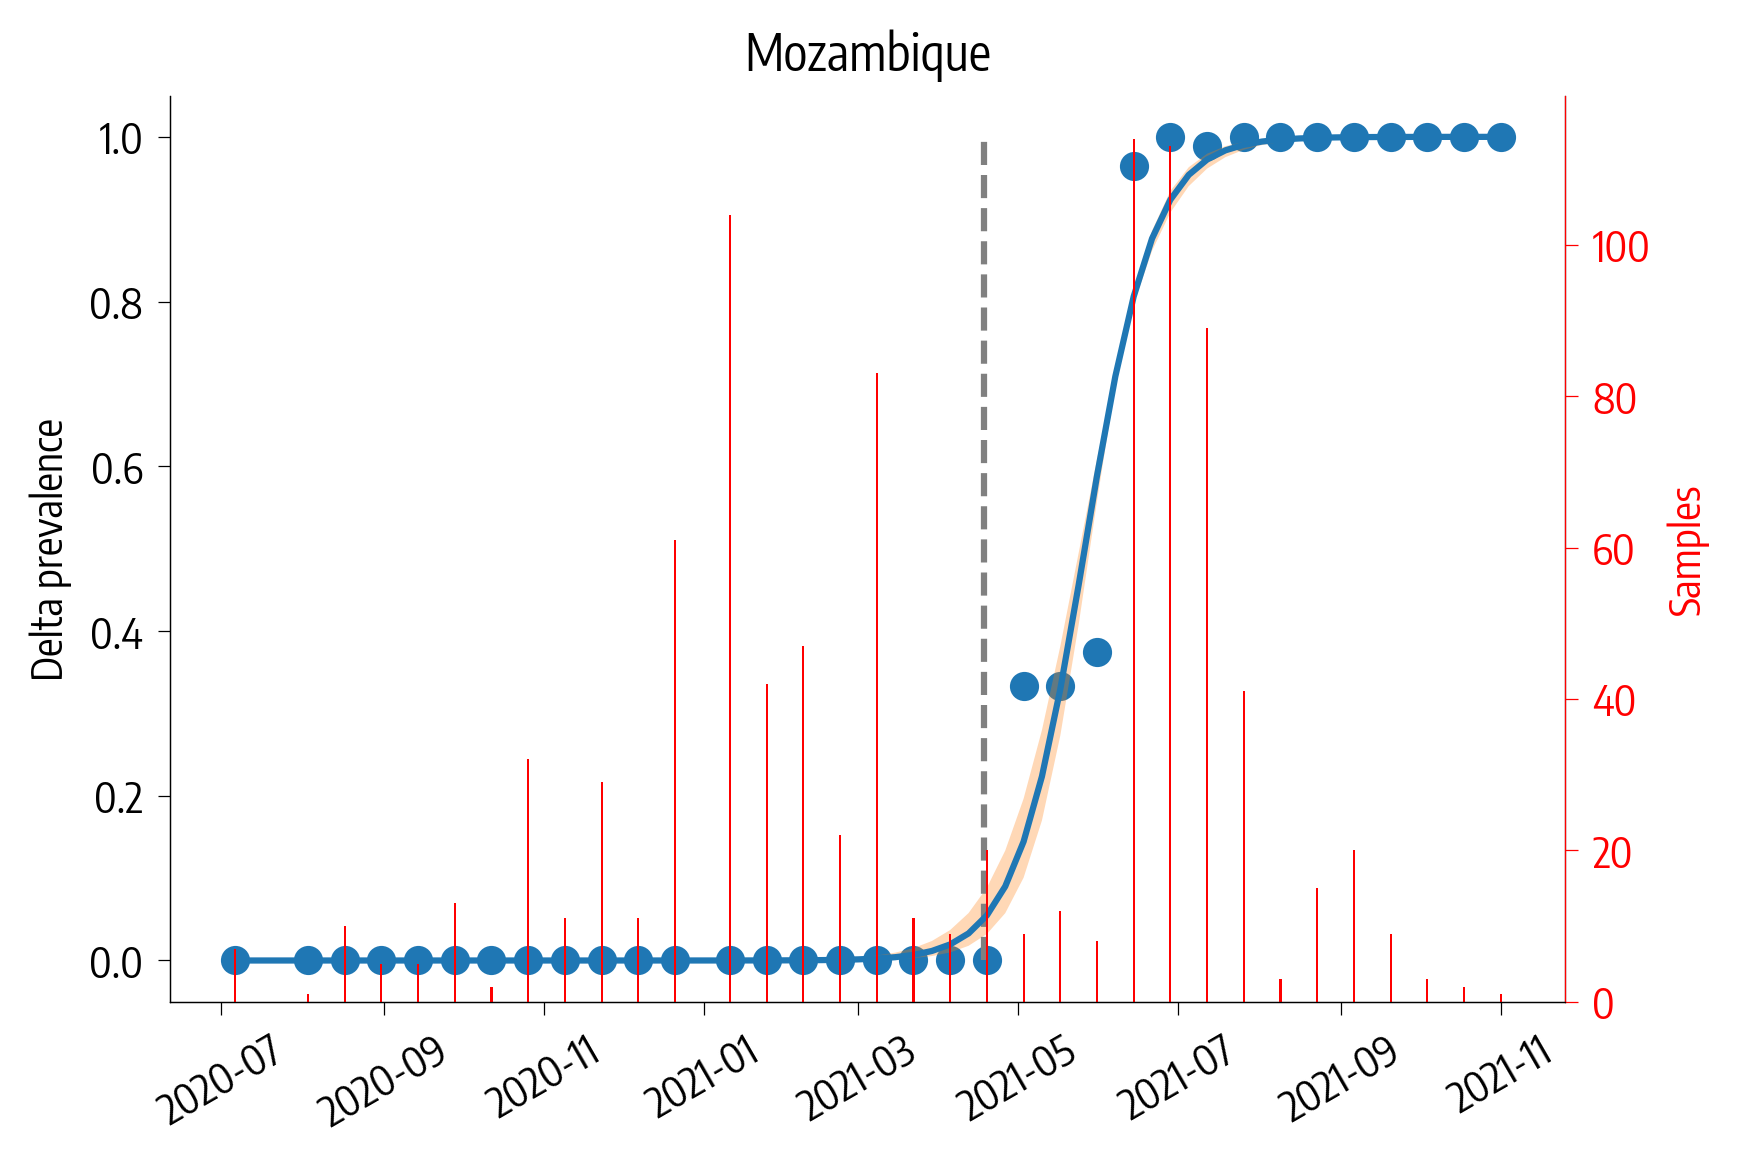

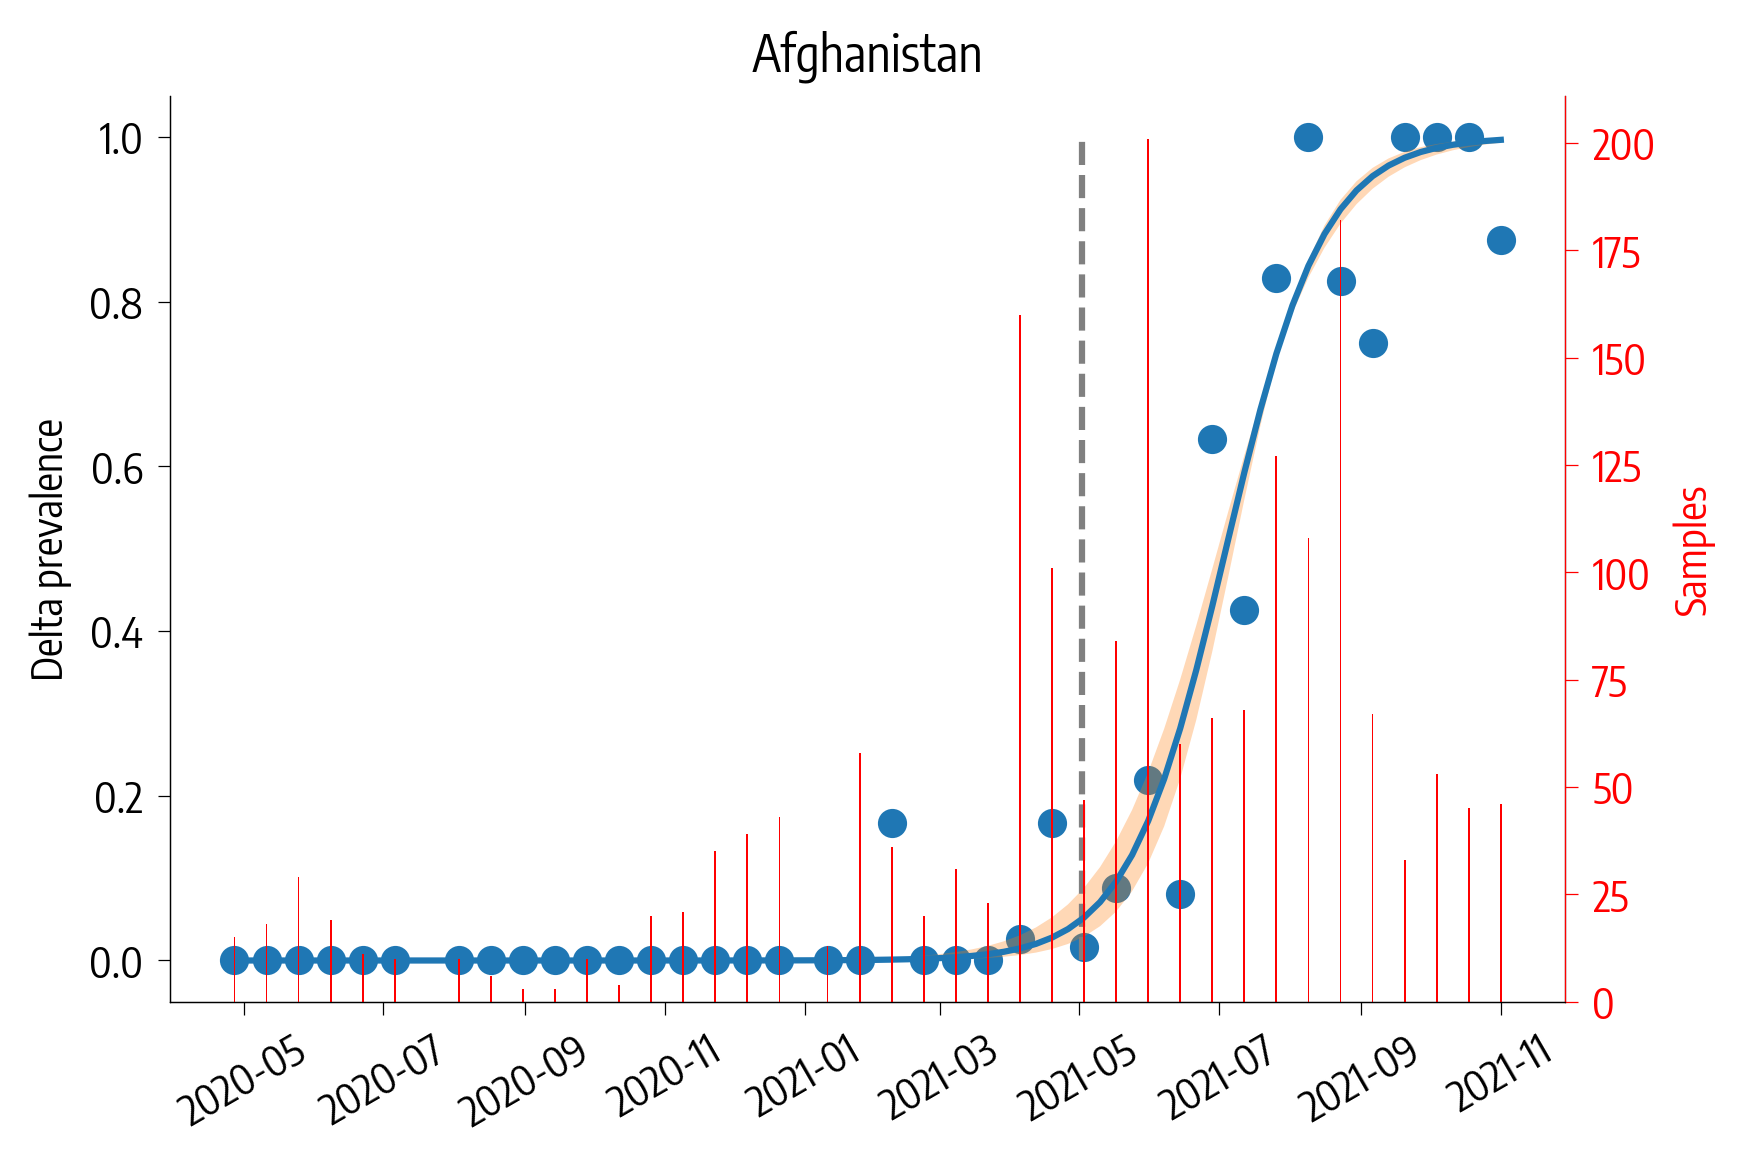

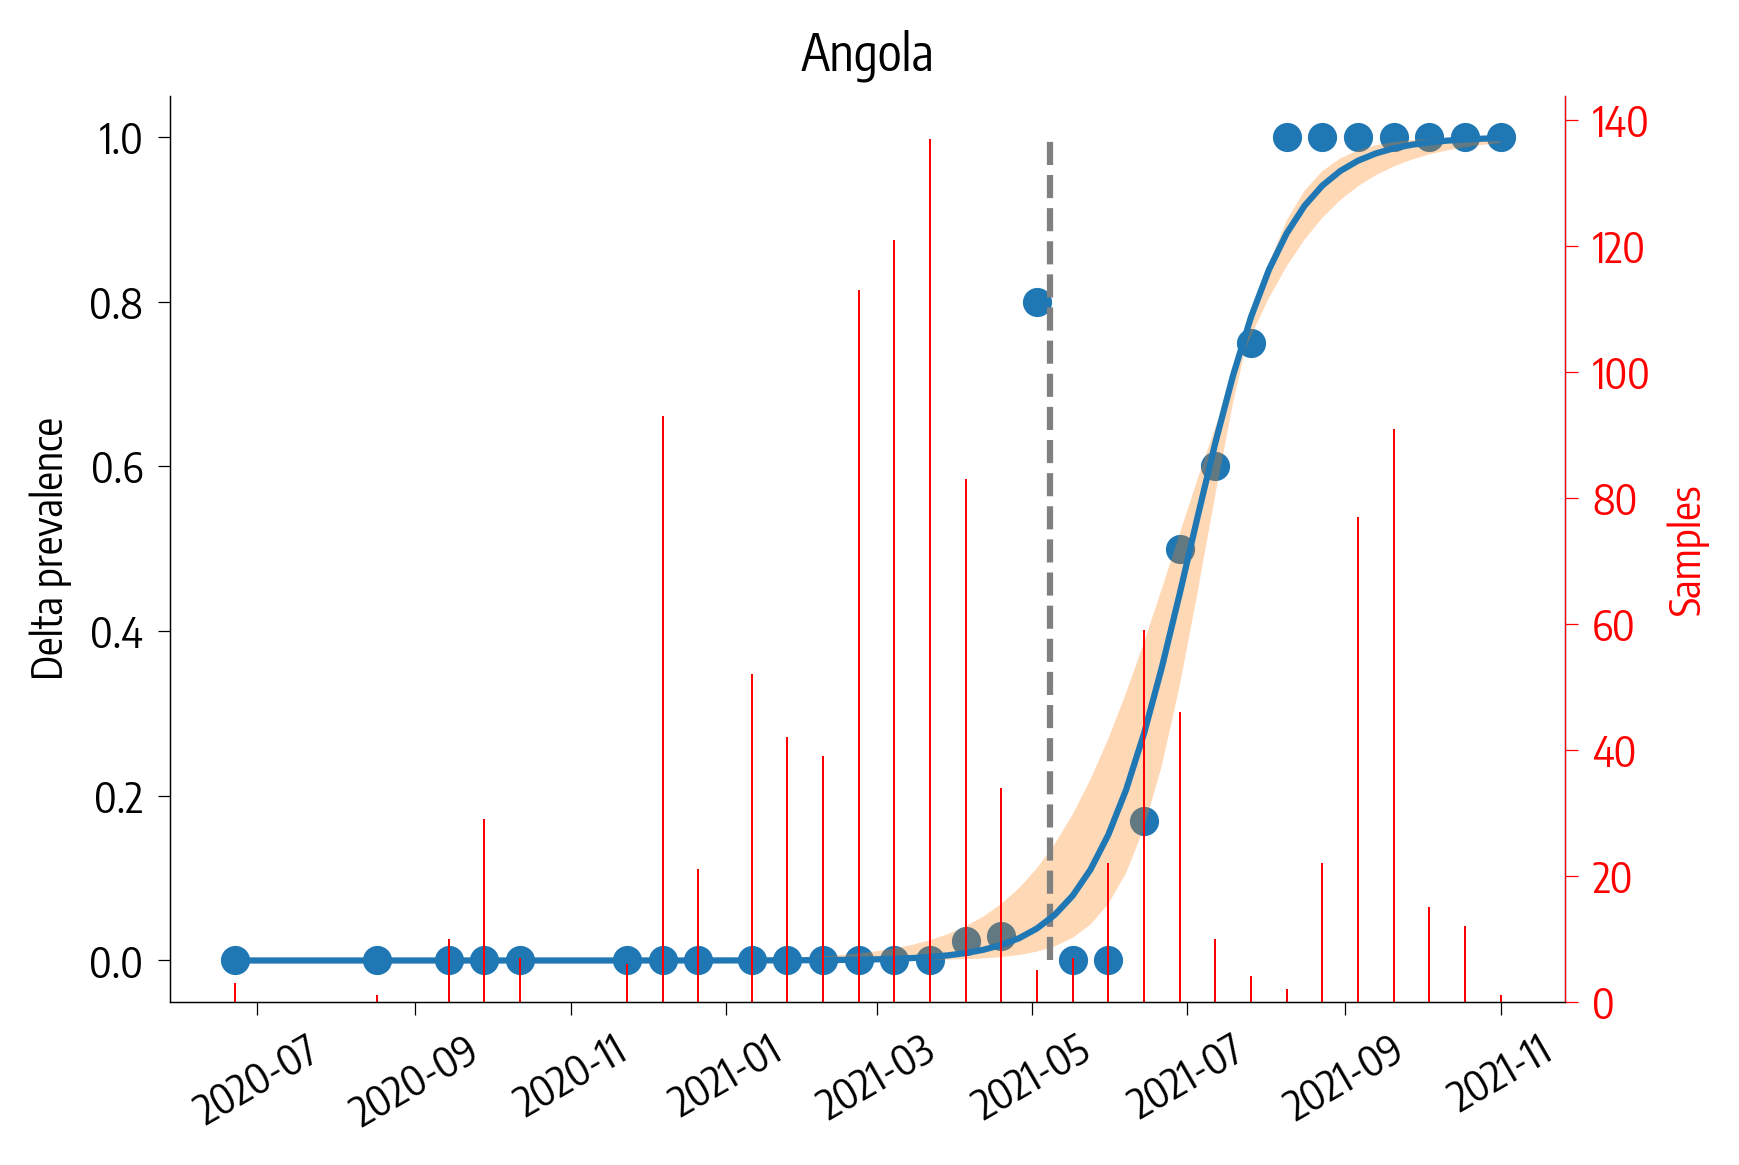

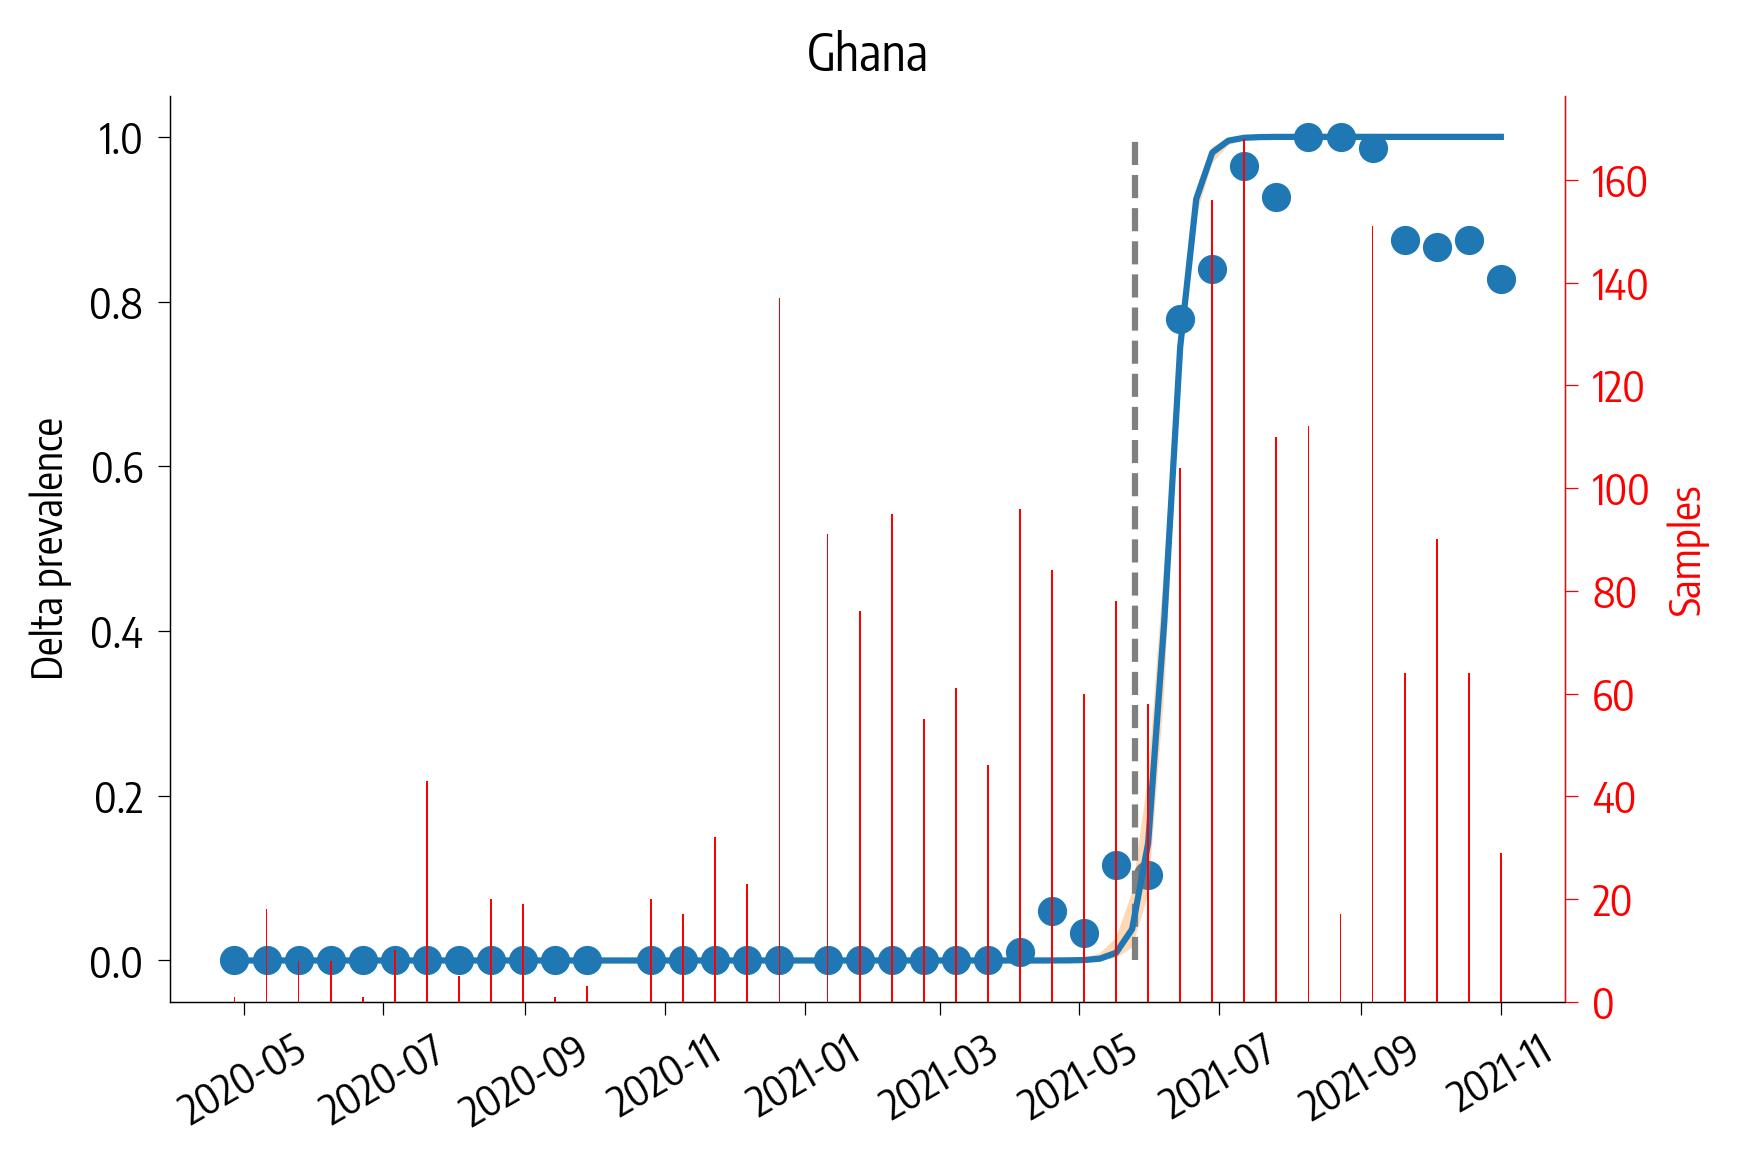

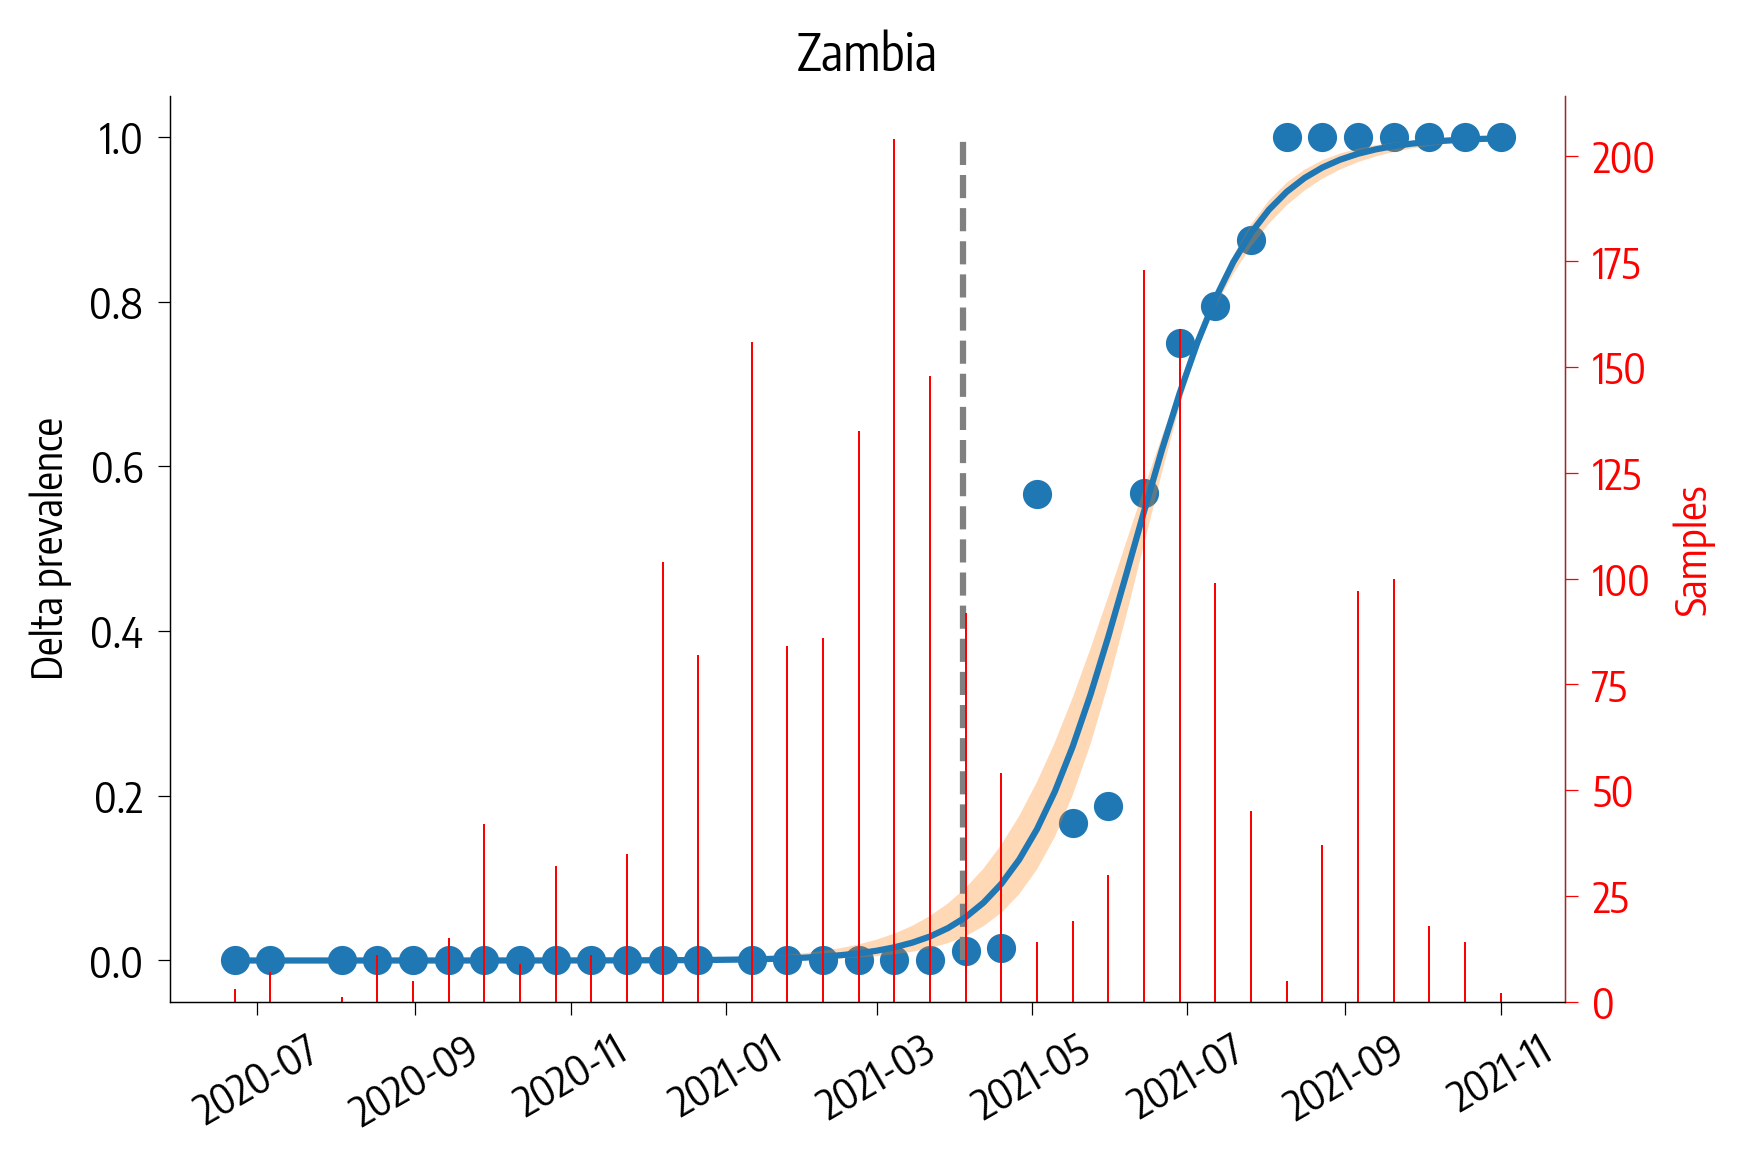

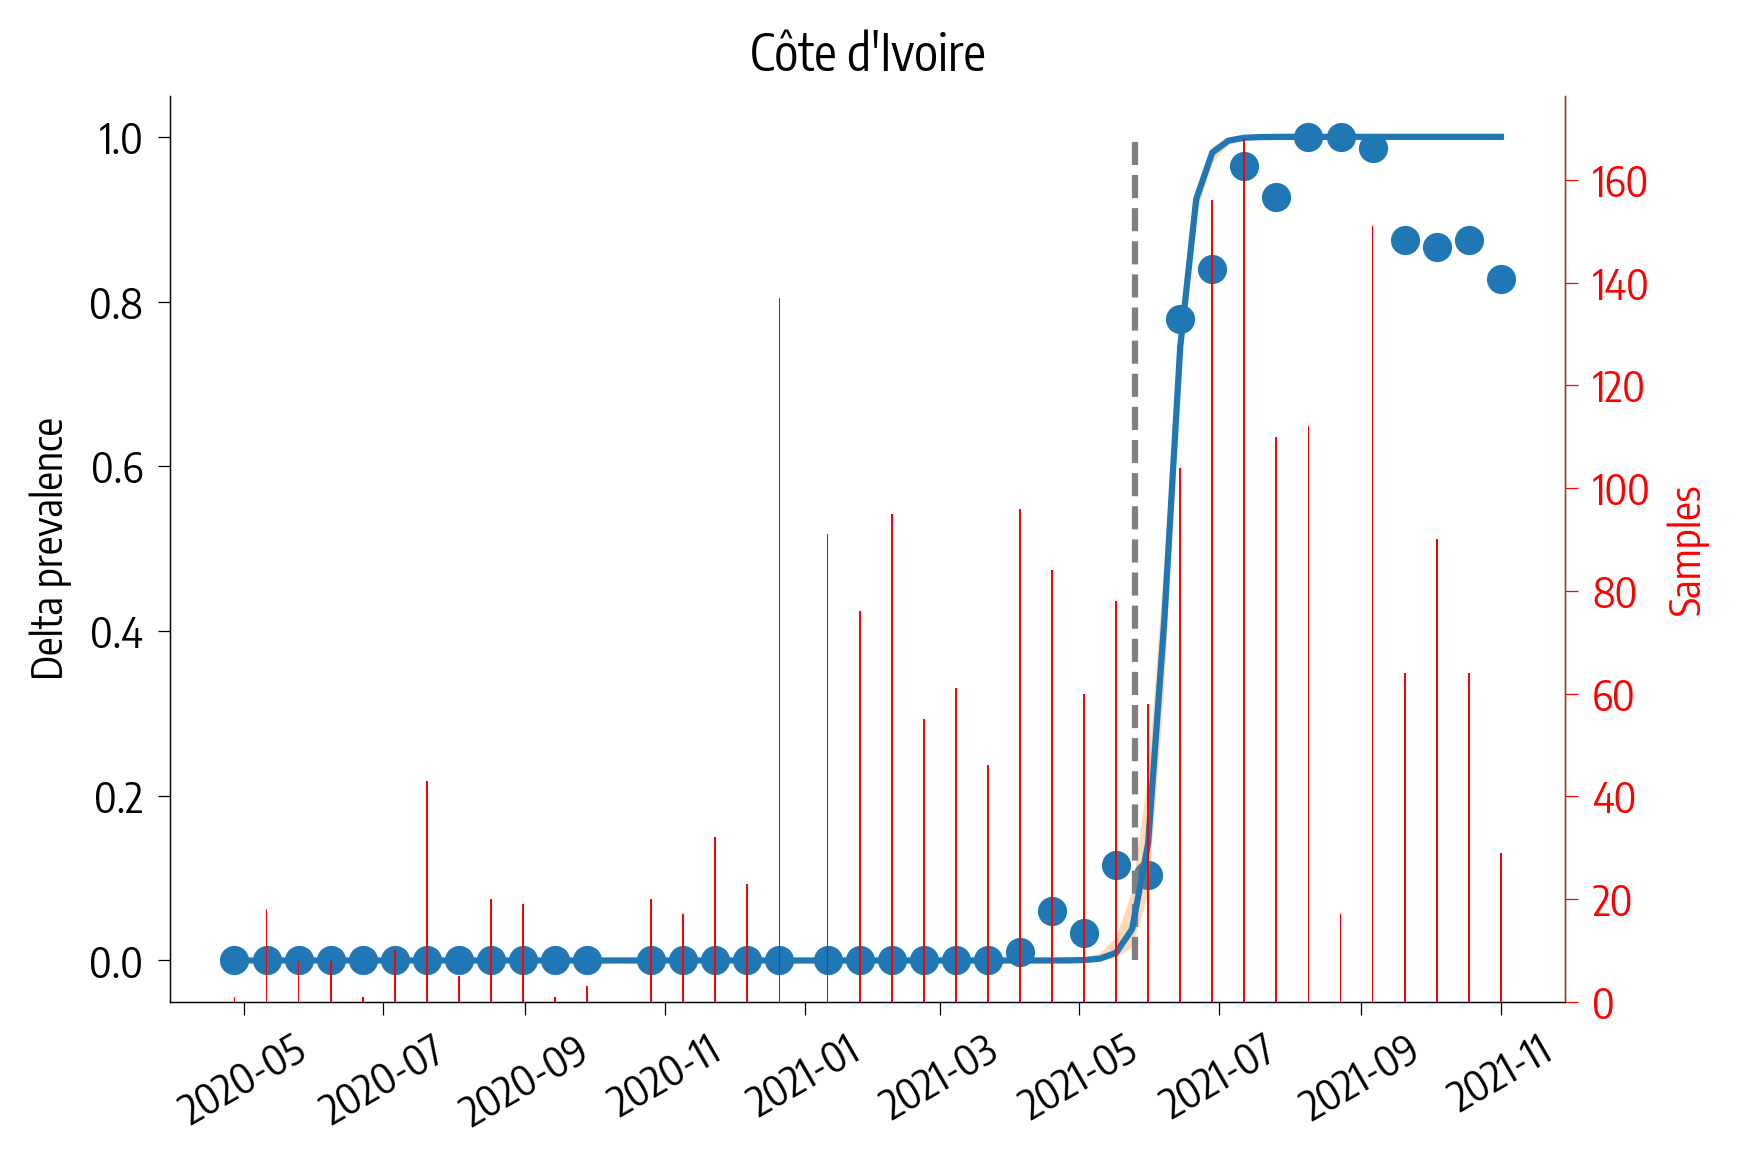

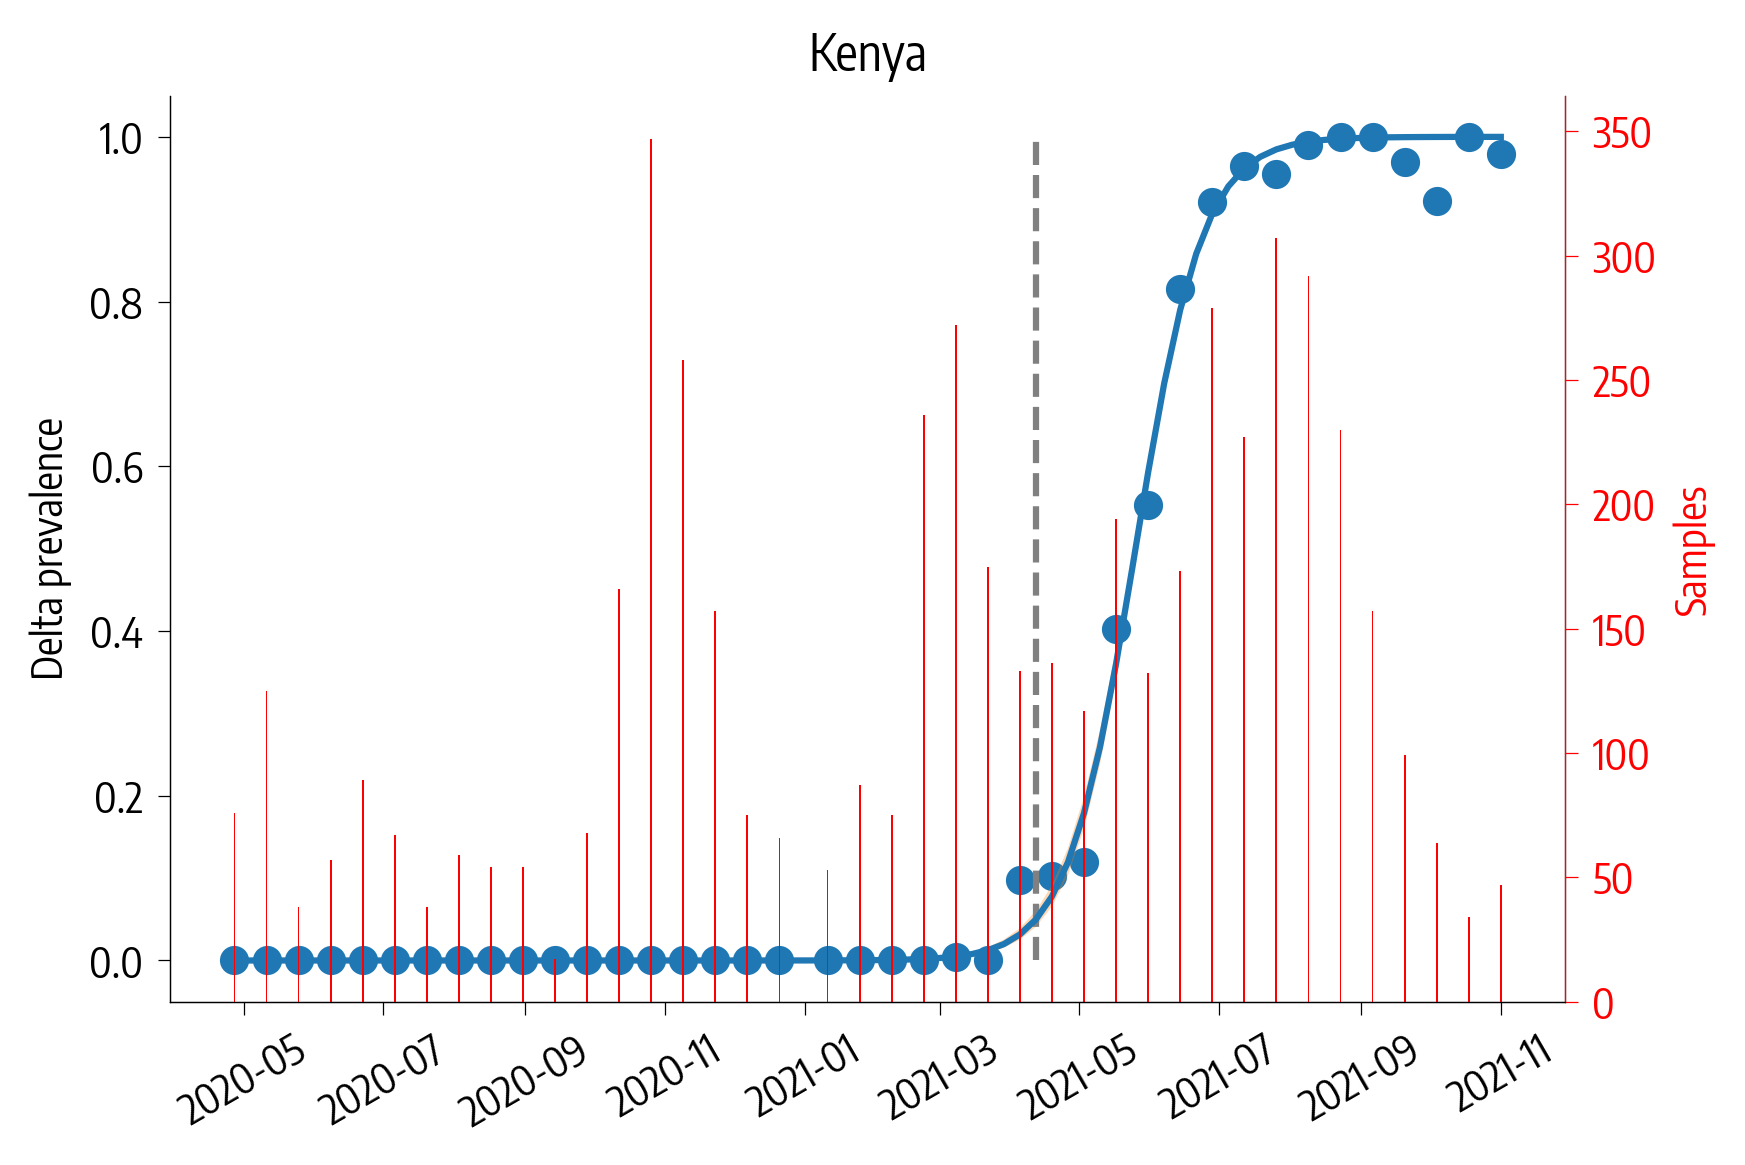

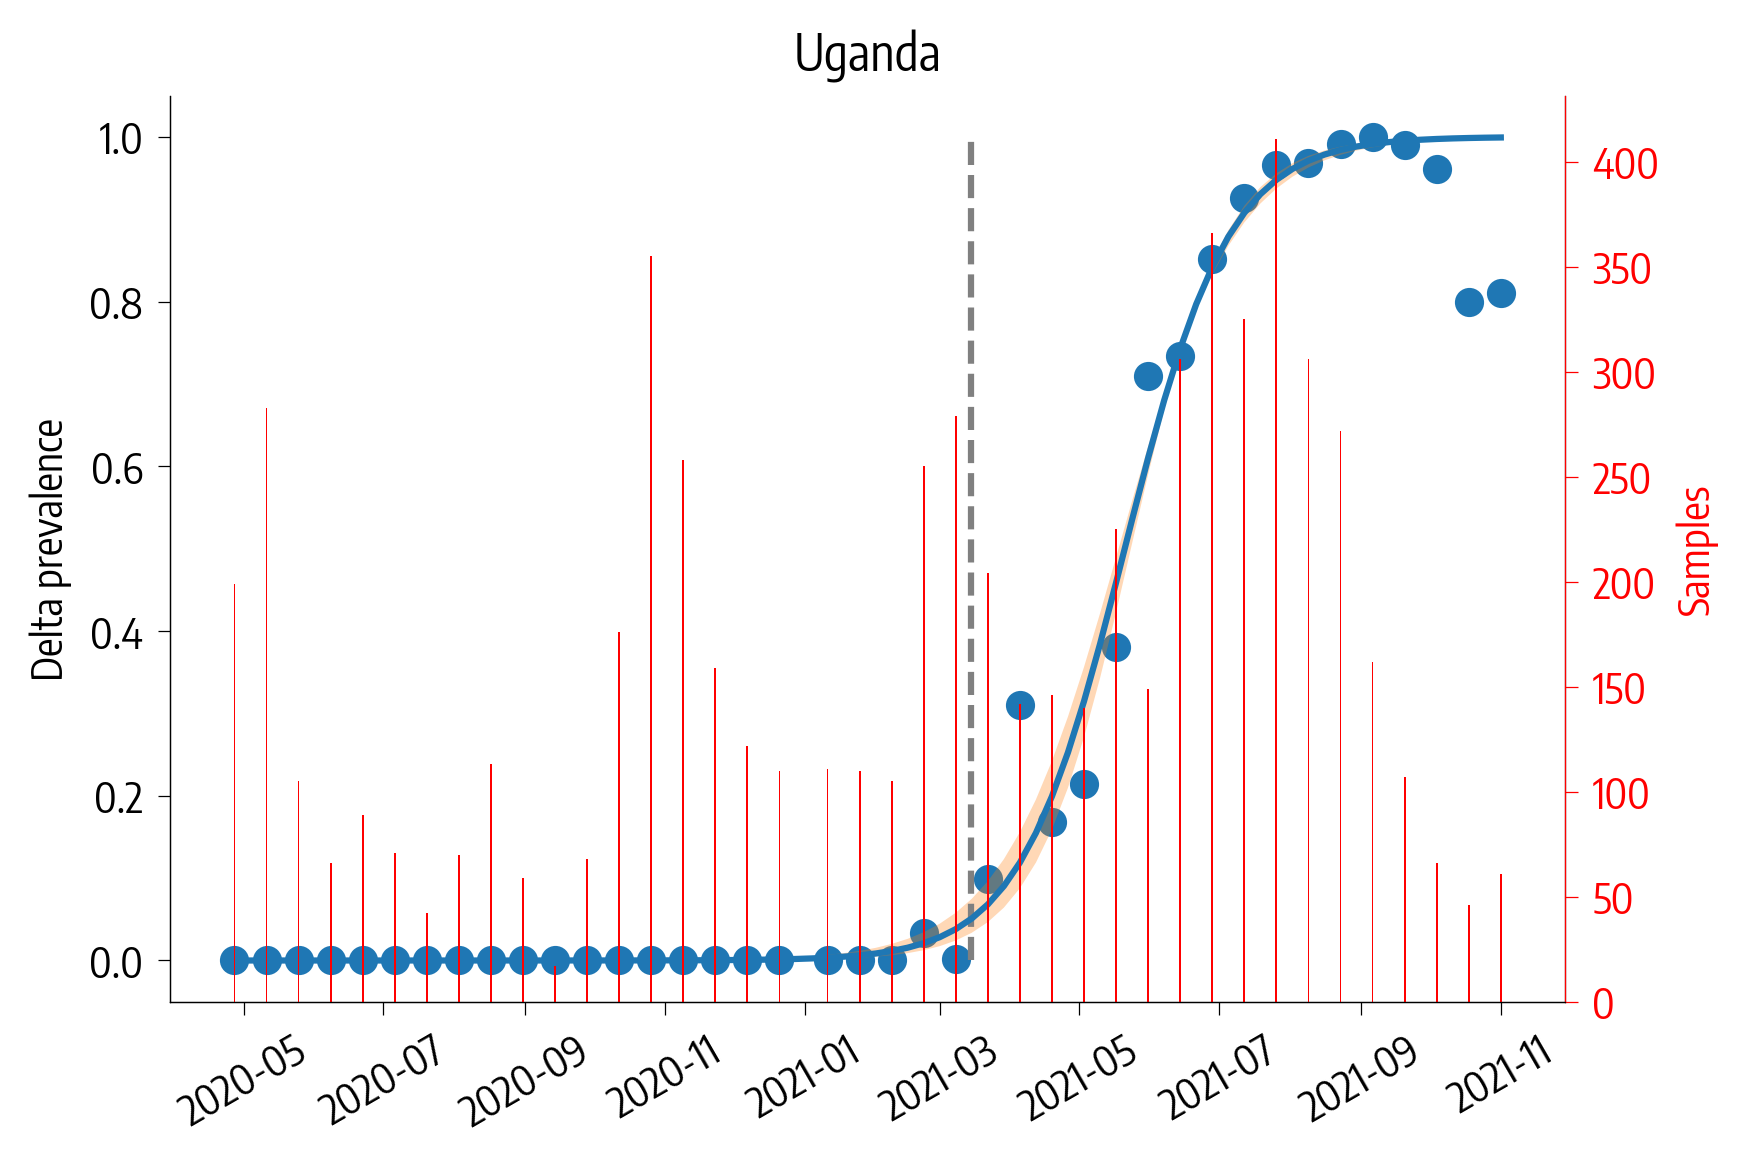

In [3]:
for country in countries:
    df_fitted, date_th = logistic_fit(country)
    fig, ax = plt.subplots(dpi=300)
    if not df_fitted.empty:

        # plot real and fitted dat
        ax.scatter(df_fitted.index, df_fitted.delta_frac)
        ax.plot(df_fitted.index, df_fitted.delta_frac_fitted)
        ax.fill_between(df_fitted.index, df_fitted.delta_frac_fitted_lower, df_fitted.delta_frac_fitted_upper, linewidth=0, alpha=0.3)
        ax2 = ax.twinx()

        # importation date (save)
        ax.vlines(date_th, 0, 1, linestyle="--", color='grey')
        print("{0}: {1}".format(country, date_th))
        pd.DataFrame(data={"date":[date_th], "prevalence_rolling": [0.051]}).to_csv("../../basins/" + country + "/variants/delta_prevalence.csv", index=False)
        
        # n samples per week
        ax2.bar(df_fitted.index, df_fitted.total_seq.values, color='red', linestyle='--')

        # plotting stuff
        ax.tick_params(axis="x", rotation=30)
        ax.set_ylabel("Delta prevalence")
        ax2.set_ylabel("Samples")
        ax.spines['top'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_color('red')
        ax2.yaxis.label.set_color('red')
        ax2.tick_params(axis='y', colors='red')

    ax.set_title(country)
    

# SI Visualization

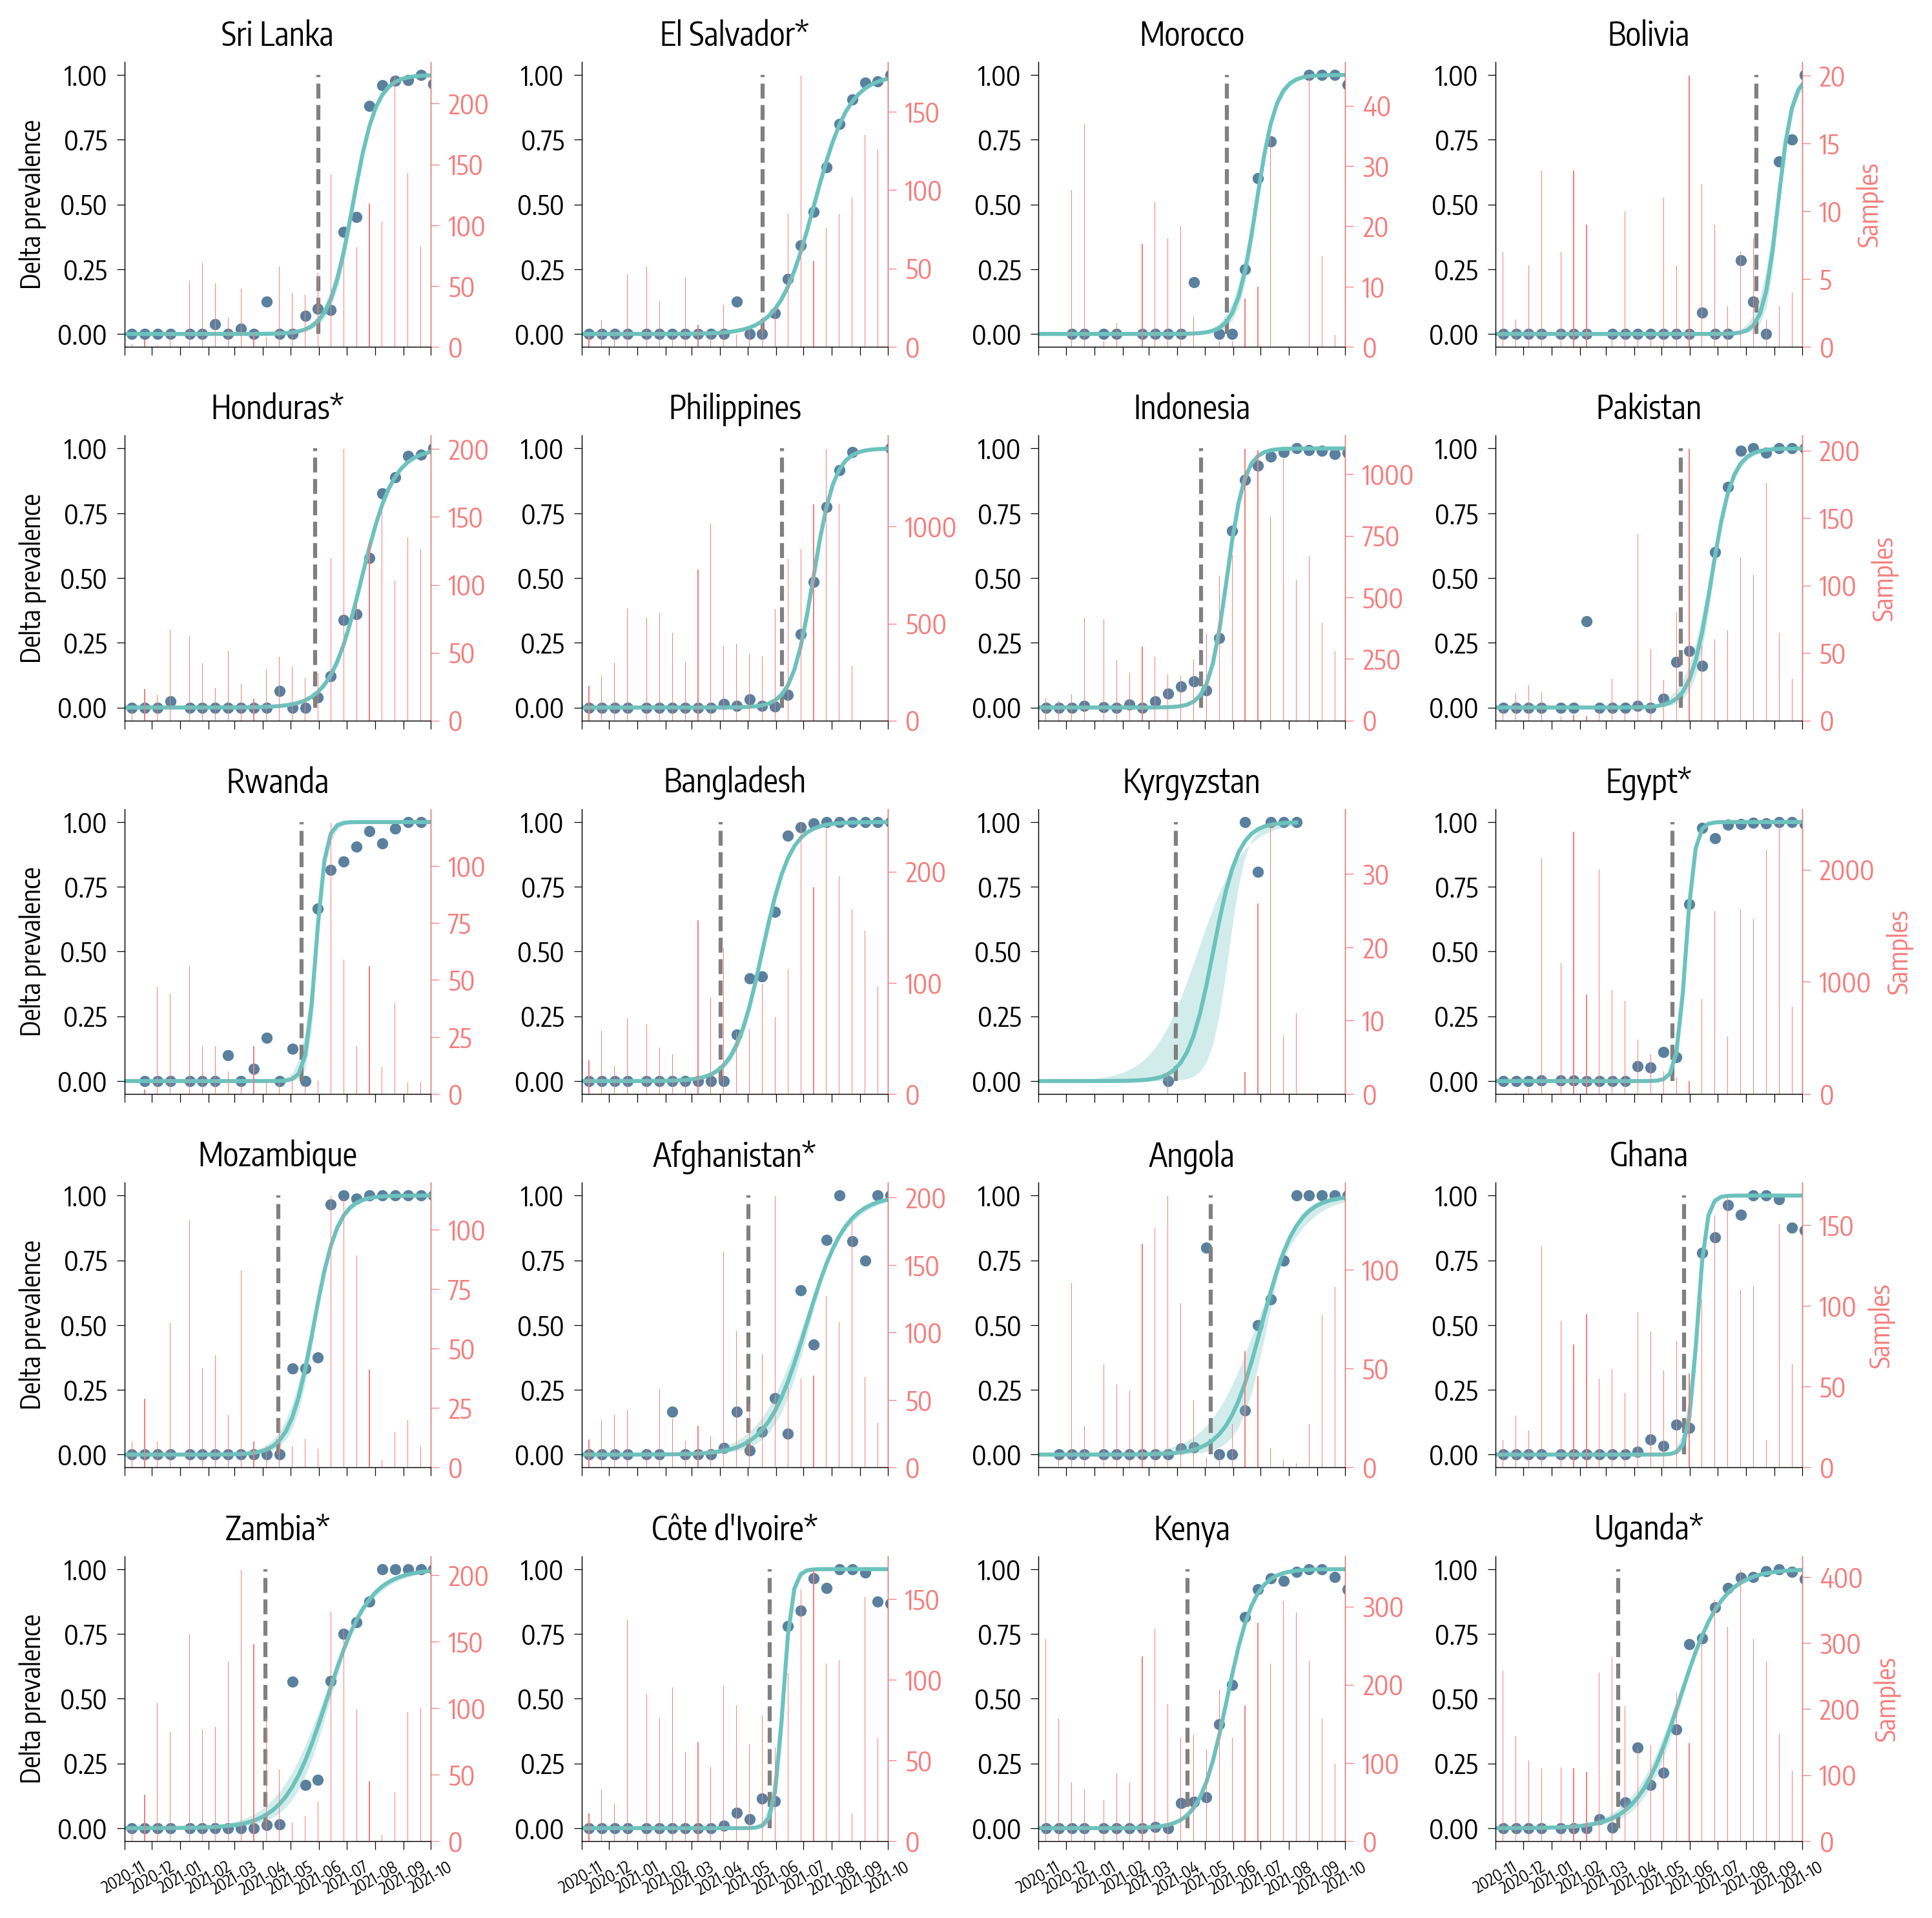

In [4]:
def logistic_fit_plot(country, ax, save=False, showlabely1=True, showlabely2=True):
    df_fitted, date_th = logistic_fit(country)
    # plot real and fitted dat
    ax.scatter(df_fitted.index, df_fitted.delta_frac, color=colors[1], s =10)
    ax.plot(df_fitted.index, df_fitted.delta_frac_fitted, color=colors[0])
    ax.fill_between(df_fitted.index, df_fitted.delta_frac_fitted_lower, df_fitted.delta_frac_fitted_upper, linewidth=0, alpha=0.3, color=colors[0])
    ax2 = ax.twinx()

    # importation date
    ax.vlines(date_th, 0, 1, linestyle="--", color='grey')
 
    # n samples per week
    ax2.bar(df_fitted.index, df_fitted.total_seq.values, color=colors[3], linestyle='--')

    # plotting stuff
    ax.tick_params(axis="x", rotation=30)
    if showlabely1:
        ax.set_ylabel("Delta prevalence")
    if showlabely2:
        ax2.set_ylabel("Samples")
    ax.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_color(colors[3])
    ax2.yaxis.label.set_color(colors[3])
    ax2.tick_params(axis='y', colors=colors[3])

    ax.set_xlim(xmin=datetime(2020, 11, 1), xmax=datetime(2021, 10, 1))
    ax.tick_params(axis="x", labelsize=6)

    if country in neighbors:
        title = country + "*"
    else:
        title = country
    ax.set_title(title)
    if save:
        print("{0}: {1}".format(country, date_th))
        pd.DataFrame(data={"date":[date_th], "prevalence_rolling": [0.051]}).to_csv("../../basins/" + country + "/variants/delta_prevalence.csv", index=False)
   

fig, axes = plt.subplots(dpi=300, ncols=4, nrows=5, sharex=True, figsize=(10,10))

i, j = 0, 0
for country in countries:

    if j==0:
        showlabely1 = True
    else:
        showlabely1 = False

    if j == 3:
        showlabely2 = True
    else:
        showlabely2 = False

    logistic_fit_plot(country, axes[i,j], save=False, showlabely1=showlabely1, showlabely2=showlabely2)
    j += 1
    if j == 4:
        j = 0
        i += 1

plt.tight_layout()
plt.savefig("./img/delta_prevalence_logfit.pdf", bbox_inches="tight")